## Imports

In [1]:
# 25.05.05 sklearn.utils.parallel_backend import문 추가

import pandas as pd
import numpy as np
from sqlalchemy import create_engine # , MetaData, Table
from backtesting import Backtest, Strategy
# from backtesting.lib import crossover
# from backtesting.test import SMA
from matplotlib import font_manager, rc
import platform

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller # coint
from datetime import datetime, timedelta
import networkx as nx  # 그래프 기반 매칭을 위해 사용

from joblib import Parallel, delayed
from sklearn.utils import parallel_backend
import numba

# 운영체제에 따라 적절한 한글 폰트 설정
if platform.system() == 'Darwin':  # macOS의 경우
    rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## Data

In [2]:
# SQLite DB 파일 경로 지정 (crypto_0415_final)
db_path = 'crypto_0415_final.db'
engine = create_engine(f'sqlite:///{db_path}')

In [3]:
price = pd.read_sql('all', engine)
price.rename(columns={'index' : 'Date'}, inplace=True)
price.set_index('Date', drop=True, inplace=True)
price.index = pd.to_datetime(price.index)
price.head()

,ETH,BTC,BCH,XRP,EOS,LTC,TRX,ETC,LINK,XLM,...,LUNA,SHIB,BAL,CTK,LUNC,SNT,BADGER,VIDT,NULS,TROY
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-01 00:00:00,1875.63,27234.32,113.1,0.5156,0.891,90.54,0.07519,18.01,6.478,0.0924,...,0.8302,0.000009,5.210,0.721,0.000085,0.02341,2.423,0.02957,0.2165,0.002536
2023-06-01 00:05:00,1875.96,27241.68,113.2,0.5160,0.890,90.62,0.07518,18.01,6.478,0.0923,...,0.8299,0.000009,5.205,0.721,0.000084,0.02351,2.419,0.02957,0.2167,0.002531
2023-06-01 00:10:00,1884.79,27318.11,113.4,0.5155,0.893,90.97,0.07533,18.04,6.502,0.0924,...,0.8331,0.000009,5.236,0.723,0.000085,0.02354,2.432,0.02964,0.2174,0.002539
2023-06-01 00:15:00,1884.79,27287.80,113.4,0.5132,0.893,91.00,0.07533,18.04,6.501,0.0921,...,0.8322,0.000009,5.237,0.723,0.000085,0.02352,2.430,0.02964,0.2178,0.002538
2023-06-01 00:20:00,1886.40,27300.99,113.4,0.5129,0.893,91.22,0.07543,18.06,6.506,0.0922,...,0.8326,0.000009,5.239,0.724,0.000085,0.02353,2.431,0.02961,0.2178,0.002535


In [4]:
price.tail()

,ETH,BTC,BCH,XRP,EOS,LTC,TRX,ETC,LINK,XLM,...,LUNA,SHIB,BAL,CTK,LUNC,SNT,BADGER,VIDT,NULS,TROY
Date,,,,,,,,,,,,,,,,,,,,,
2025-04-14 23:40:00,1619.09,84465.82,323.1,2.1254,0.6104,76.99,0.2518,15.20,12.60,0.2396,...,0.1586,0.000012,0.871,0.3123,0.000058,0.01887,0.883,0.00195,0.0300,0.000132
2025-04-14 23:45:00,1620.31,84540.00,323.8,2.1261,0.6113,77.13,0.2517,15.22,12.62,0.2398,...,0.1586,0.000012,0.871,0.3125,0.000058,0.01885,0.879,0.00196,0.0294,0.000128
2025-04-14 23:50:00,1621.24,84495.11,323.7,2.1266,0.6117,77.09,0.2519,15.22,12.61,0.2398,...,0.1586,0.000012,0.871,0.3105,0.000058,0.01895,0.879,0.00199,0.0290,0.000129
2025-04-14 23:55:00,1623.77,84591.58,323.6,2.1275,0.6121,77.18,0.2521,15.23,12.63,0.2399,...,0.1589,0.000012,0.867,0.3113,0.000058,0.01888,0.880,0.00198,0.0294,0.000130
2025-04-15 00:00:00,1623.16,84502.19,323.5,2.1251,0.6134,76.96,0.2521,15.20,12.61,0.2397,...,0.1585,0.000012,0.866,0.3114,0.000058,0.01881,0.886,0.00193,0.0297,0.000128


## Source
* line 299, 300: trade_df global화 했음

In [35]:
class PairSelector:
    def __init__(self, prices):
        self.prices = prices
        self.pairs = self.generate_pairs()
        self.filtered_pairs_1 = []
        self.filtered_pairs_2 = []
        print(f"[PairSelector] 총 후보 페어 개수: {len(self.pairs)}")

    def generate_pairs(self):
        tickers = self.prices.columns.tolist()
        pairs = []
        for i in range(len(tickers)):
            for j in range(i+1, len(tickers)):
                pairs.append((tickers[i], tickers[j]))
        return pairs
 
    def filter_pairs_mr(self, pair):
        try:
            price1 = self.prices[pair[0]]
            price2 = self.prices[pair[1]]
            
            x = price2.values
            y = price1.values
            beta = np.cov(x, y, ddof=0)[0, 1] / np.var(x)
            alpha = np.mean(y) - beta * np.mean(x)
            spread = price1 - beta * price2 - alpha

            # 전체 기간에 대해 z-score 계산
            zscore = (spread - spread.mean()) / spread.std()

            # z-score가 극단치(절대값 >=2)에 도달한 후 0(또는 tol 이하)로 회귀하는 이벤트 횟수 측정
            event_count = self._count_mean_reversion_events(zscore.to_numpy(), threshold=3.5, tol=1)
            if event_count > 0:
                return (pair, event_count)

        except Exception as e:
            print(f"Error in filter_pairs_mean_reversion for {pair}: {e}")
            return None
    
    @staticmethod
    @numba.njit
    def _count_mean_reversion_events(zscore_arr, threshold=1, tol=0.5):
        """
        Numba JIT 컴파일을 적용한 버전.
        zscore_arr: NumPy 배열 형태의 zscore 값들.
        threshold: 극단치 기준
        tol: 회귀(0에 가까운) 기준
        """
        count = 0
        in_extreme = False
        for i in range(len(zscore_arr)):
            val = zscore_arr[i]
            if not in_extreme:
                if np.abs(val) >= threshold:
                    in_extreme = True
            else:
                if np.abs(val) <= tol:
                    count += 1
                    in_extreme = False
        return count
    
    def run(self):
        corr_matrix = self.prices.corr()
        tickers = self.prices.columns.tolist()
        corr_pairs = []
        for i in range(len(tickers)):
            for j in range(i+1, len(tickers)):
                if abs(corr_matrix.loc[tickers[i], tickers[j]]) >= 0.6 and abs(corr_matrix.loc[tickers[i], tickers[j]]) <= 0.8:
                    corr_pairs.append((tickers[i], tickers[j]))
        print(f'첫 번째 필터 통과 페어 개수: {len(corr_pairs)}개')

        with parallel_backend("threading", n_jobs=-1):
            results2 = Parallel(verbose=1)(
                delayed(self.filter_pairs_mr)(pair) for pair in corr_pairs
            )
        results2 = [r for r in results2 if r is not None]
        # 이벤트 횟수(event_count)를 기준으로 내림차순 정렬하여 상위 20개 페어 선택
        results2_sorted = sorted(results2, key=lambda x: x[1], reverse=True)
        top_20 = results2_sorted[:30]
        top_20_list = []

        # for pair, count in top_20:
        #     top_20_list.append(pair)

        # # 가장 많이 등장하는 종목(자산)을 찾은 후, 해당 종목이 포함된 페어들만 필터링
        # from collections import Counter
        # asset_counter = Counter()
        # for pair in top_20_list:
        #     asset_counter.update(pair)
        # most_common_asset = asset_counter.most_common(1)[0][0]
        # filtered_pairs = [pair for pair in top_20_list if most_common_asset in pair]
        # return filtered_pairs
    
        # print(f'상위 20개 페어 (페어, 이벤트 횟수):')
        for pair, count in top_20:
            print(f'{pair} - 이벤트 횟수: {count}')
            top_20_list.append(pair)

        return top_20_list #corr_pairs#top_20_list

class HalfLifeEstimator:
    def __init__(self, prices, pairs):
        self.prices = prices
        self.pairs = pairs
        self.pair_stats = {}
        
    def estimate_half_life(self, spread):
        delta_spread = spread.diff().dropna()  # ΔS_t = S_t - S_t-1 계산
        spread_lag = spread.shift(1).dropna()  # S_t-1 생성 (이전 시점의 스프레드)
        spread_lag, delta_spread = spread_lag.align(delta_spread, join='inner')  # ΔS_t와 S_t-1 맞춤

        # 회귀 분석 수행하여 θ 추정
        theta_model = sm.OLS(delta_spread, sm.add_constant(spread_lag)).fit()
        theta = -theta_model.params[0]  # θ 추정값 (음수 부호 주의)

        if theta > 0:
            halflife = np.log(2) / (theta) 
        else:
            halflife = np.nan

        return halflife

    def filter_pairs_mr(self, pair):
        try:
            price1 = self.prices[pair[0]]
            price2 = self.prices[pair[1]]
            x = price2.values
            y = price1.values
            beta = np.cov(x, y, ddof=0)[0, 1] / np.var(x)
            alpha = np.mean(y) - beta * np.mean(x)
            spread = price1 - beta * price2 - alpha
            halflife = self.estimate_half_life(spread)
            #adf_result = adfuller(spread)

            if np.isfinite(halflife) and halflife > 0:
                return pair, {
                    'halflife': halflife, 
                    'alpha': alpha, 
                    'beta': beta, 
                    'spread': spread
                    # 'adf': adf_result[0],
                    # 'p-val' : adf_result[1]
                }
            else:
                return None, None
        except Exception as e:
            print(f"Error for pair {pair}: {e}")
            return None, None

    def select_pairs_graph(self, k):
        # 각 후보 페어에 대해 halflife, alpha, beta, spread, 분산 등을 계산
        with parallel_backend("threading", n_jobs=-1):
            results = Parallel(verbose=1)(
                delayed(self.filter_pairs_mr)(pair) for pair in self.pairs
            )
        matching_list = []
        for pair, stats_dict in results:
            if pair is not None and stats_dict is not None:

                beta_val = stats_dict['beta']
                #p_val = stats_dict['p-val']
                if beta_val >= 0: # stats_dict['beta'] <= 4: # stats_dict['p-val'] <= 0.01 and  #and stats_dict['beta'] >= 0.2 and stats_dict['beta'] <= 1.8:
                    weight = stats_dict['halflife'] 
                    matching_list.append((pair, weight, stats_dict))

        print(f'halflife 필터에서 살아남은 페어의 개수는 {len(matching_list)}개입니다---------')

        matching_list = sorted(matching_list, key=lambda x: x[1])
        selected = matching_list[:k]
        selected_pairs = [(pair, stats) for (pair, weight, stats) in selected]
        # print(f"[HalfLifeEstimator.select_pairs_graph] 선택된 페어 수: {len(selected_pairs)}")
        return selected_pairs
    
class TradingStrategy:
    def __init__(self, prices, pair, alpha, beta, lookback, test_index, transaction_cost):
        self.prices = prices
        self.pair = pair
        self.lookback = lookback
        self.alpha = alpha
        self.beta = beta
        self.test_index = test_index
        self.transaction_cost = transaction_cost
        self.spread = None
        self.zscore = None
        self.positions = None
        self.zscore_st = None
        
    def calculate_spread(self):
        price1 = self.prices[self.pair[0]]
        price2 = self.prices[self.pair[1]]
        self.spread = price1 - self.beta * price2 - self.alpha  # 스프레드 계산

    def calculate_zscore(self):
        # EWMA 기반 z-score 계산
        spread_mean = self.spread.ewm(span=self.lookback, adjust=False).mean()
        spread_std = self.spread.ewm(span=self.lookback, adjust=False).std()
        # spread_mean = self.spread.rolling(self.lookback).mean()
        # spread_std = self.spread.rolling(self.lookback).std()
        self.zscore = (self.spread - spread_mean) / spread_std
        self.zscore = self.zscore[self.test_index]
        return self.zscore
    
    def generate_signals(self):
        self.positions = pd.DataFrame(index=self.zscore.index)
        self.zscore_st = self.zscore.ewm(span=self.lookback, adjust=False).std()
        upper_entry = self.zscore_st * 2
        lower_entry = -upper_entry
        upper_exit = self.zscore_st
        lower_exit = -upper_exit
        position_list = [0, 0]

        for t in range(2, len(self.zscore)):

            if t == len(self.zscore) - 1:
                position_list.append(0)
                continue

            current_z = self.zscore.iloc[t]
            z_t1 = self.zscore.iloc[t-1]
            z_t2 = self.zscore.iloc[t-2]
            current_signal = position_list[-1]

            #long entry
            if z_t1 < lower_entry.iloc[t-1] and z_t2 >= lower_entry.iloc[t-2] and current_z < lower_entry.iloc[t] and current_z > -5: # and self.zscore.iloc[t] > -4:
                new_signal = 1
            # Long Exit
            elif current_z > lower_exit.iloc[t] and z_t1 > lower_exit.iloc[t-1] and z_t2 <= lower_exit.iloc[t-2]:
                new_signal = 0
            #short entry
            elif z_t1 > upper_entry.iloc[t-1] and z_t2 <= upper_entry.iloc[t-2] and current_z > upper_entry.iloc[t] and current_z < 5: # and self.zscore.iloc[t] < 4:
                new_signal = -1
            # Short Exit
            elif current_z < upper_exit.iloc[t] and z_t1 < upper_exit.iloc[t-1] and z_t2 >= upper_exit.iloc[t-2]:
                new_signal = 0
            else:
                new_signal = current_signal
            
            position_list.append(new_signal)
        self.positions['Position'] = position_list

class BaseTradingStrategy(TradingStrategy):

    def calculate_zscore(self):
        spread_mean = self.spread.mean()
        spread_std = self.spread.std()
        self.zscore = (self.spread - spread_mean) / spread_std
        self.zscore = self.zscore[self.test_index]
        return self.zscore

    def generate_signals(self):
        self.positions = pd.DataFrame(index=self.zscore.index)
        pos = [0]
        for t in range(1, len(self.zscore)):
            z = self.zscore.iloc[t]
            prev = pos[-1]
            if prev==0:
                if z>2:      curr = -1
                elif z<-2:   curr = 1
                else:        curr = 0
            elif prev==1 and z>=0:
                curr = 0
            elif prev==-1 and z<=0:
                curr = 0
            else:
                curr = prev
            pos.append(curr)
        self.positions['Position'] = pos

class Backtester:
    def __init__(self, prices, start_date, end_date, transaction_cost=0.0005):
        self.prices = prices
        self.start_date = start_date
        self.end_date = end_date
        self.transaction_cost = transaction_cost
        self.results = pd.DataFrame()
        self.trade_logs = []  # 각 구간별 거래 로그 저장
        print(f"[Backtester] 초기화: {start_date} ~ {end_date}, 수수료: {transaction_cost}")
        
    def run_baseline_backtest(self, capital=10000):
        btc = self.prices['BTC'].copy()
        btc = btc.loc[self.start_date:self.end_date]
        btc = btc.dropna()
    
        # 기준 시점의 가격
        entry_price = btc.iloc[0]
        equity = btc / entry_price * capital
    
        df = pd.DataFrame({
            'Equity': equity,
            'Cumulative Return (%)': (equity / capital - 1) * 100
        }, index=btc.index)
        return df

    def run_backtest(self, ref_days=180, trade_days=7, initial_capital=10000):
        start_dt = datetime.strptime(self.start_date, "%Y-%m-%d")
        end_dt = datetime.strptime(self.end_date, "%Y-%m-%d")
        backtest_start = start_dt + pd.Timedelta(days=ref_days)
        date_range = pd.date_range(start=backtest_start, end=end_dt, freq=f'{trade_days}d')
        # ij: trade_df global 선언. 진행과정 따로 확인 위함
        global trade_df # ij

        if date_range[-1] < end_dt:
            date_range = date_range.append(pd.DatetimeIndex([end_dt]))

        df_portfolio = pd.DataFrame({'Exit Time' : [date_range[0]], 'Cumulative Return (%)' : [0]})
        fixed_capital = initial_capital

        for i in range(len(date_range) - 1): #

            test_start = date_range[i]
            test_end = date_range[i+1]
            train_end = test_start
            train_start = train_end - pd.Timedelta(days=ref_days)
            print(f"\n[Backtester.run_backtest] LOOKBACK: {train_start.date()} ~ {train_end.date()} | Trade: {test_start.date()} ~ {test_end.date()}")

            train_data = self.prices.loc[train_start:train_end]
            test_data = self.prices.loc[test_start:test_end]
            new_train_data = np.log(train_data)
            new_test_data = np.log(test_data)
            combined_data = pd.concat([new_train_data, new_test_data.iloc[1:]])
            print(f"[Backtester.run_backtest] 학습+테스트 데이터 준비 완료, 길이: {len(combined_data)}")

            pair_selector = PairSelector(new_train_data)
            filtered_pairs = pair_selector.run()
            print(f"[Backtester.run_backtest] 필터 통과 페어 수: {len(filtered_pairs)}")

            half_life_estimator = HalfLifeEstimator(new_train_data, filtered_pairs)
            sorted_pairs = half_life_estimator.select_pairs_graph(5)

            n_pairs = len(sorted_pairs)
            if n_pairs == 0:
                print(f"[Backtester.run_backtest] 선정된 페어 없음; 구간 스킵")
                continue
            else:
                print(f"[Backtester.run_backtest] 여러 페어 선택: {n_pairs}개, 전체 시작 자본: {initial_capital}")

            all_signals = {}
            all_beta = {}

            for pair, stats_dict in sorted_pairs:

                print(f"[Backtester.run_backtest] 페어 {pair} 거래 구간 시작, beta값 : {stats_dict['beta']}, Lookback = {int(round(stats_dict['halflife']))}")
                strategy = TradingStrategy(combined_data, pair, stats_dict['alpha'], stats_dict['beta'], int(round(stats_dict['halflife'])), new_test_data.iloc[1:].index, self.transaction_cost) #int(round(stats_dict['halflife']))
                strategy.calculate_spread()
                strategy.calculate_zscore()
                strategy.generate_signals()
                all_signals[pair] = strategy.positions
                all_beta[pair] = stats_dict['beta']

            trade_df = integrated_record_trades(all_signals, test_data, self.transaction_cost, all_beta, capital=initial_capital/n_pairs)
            
            if not trade_df.empty:
                print("\n=== Trade Records ===")
                print(trade_df)
                updated_capital = trade_df['Total Capital'].iloc[-1]
                initial_capital = updated_capital
            else:
                print(f"  페어 {pair}: 거래 기록 없음, 자본 유지")
                
            
            total_capital = initial_capital
            cumulative_return = (total_capital / fixed_capital) - 1
            print(f"[Backtester.run_backtest] 구간 {i+1} 후 포트폴리오 자본: {total_capital:.2f}, 누적 수익률: {cumulative_return*100:.2f}%")
            df_portfolio = pd.concat([df_portfolio, pd.DataFrame({'Exit Time': [test_end], 'Cumulative Return (%)': [cumulative_return]})], ignore_index=True)
        
        df_portfolio.set_index('Exit Time', inplace=True)
        plt.figure(figsize=(12, 6))
        plt.plot(df_portfolio.index, df_portfolio['Cumulative Return (%)']*100, label='Cumulative Return (%)', lw=2)
        plt.xlabel('Time')
        plt.ylabel('Cumulative Return (%)')
        plt.title('Cumulative Return (%) Over All Trade Periods')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        overall_capital = initial_capital
        overall_return = (overall_capital / fixed_capital) - 1
        print(f"\n=== 전체 포트폴리오 최종 자본: {overall_capital:.2f}, 누적 수익률: {overall_return*100:.2f}% ===")
        return df_portfolio
    
def plot_trade_details(test_data, strategy, signals, trade_df, pair):
    # 임계값(threshold) 계산
    # long_entry_threshold = [2] * len(strategy.zscore.index)        
    # short_entry_threshold = [-2] * len(strategy.zscore.index)
    # long_exit_threshold = [1] * len(strategy.zscore.index)
    # short_exit_threshold = [-1] * len(strategy.zscore.index)

    long_entry_threshold = strategy.zscore_st * 2.5       # 예: red
    short_entry_threshold = -strategy.zscore_st * 2.5        # 예: green
    long_exit_threshold = strategy.zscore_st            # 예: blue
    short_exit_threshold = -strategy.zscore_st            # 예: purple

    fig, ax = plt.subplots(figsize=(14, 7))
    # z-score 플롯
    ax.plot(strategy.zscore.index, strategy.zscore, label="Z-Score", color='black', lw=2)
    # 임계값 플롯 (각각 다른 색상과 linestyle)
    ax.plot(strategy.zscore.index, long_entry_threshold, label="Long Entry Threshold", linestyle='--', color='red')
    ax.plot(strategy.zscore.index, short_entry_threshold, label="Short Entry Threshold", linestyle='--', color='green')
    ax.plot(strategy.zscore.index, long_exit_threshold, label="Long Exit Threshold", linestyle='-.', color='blue')
    ax.plot(strategy.zscore.index, short_exit_threshold, label="Short Exit Threshold", linestyle='-.', color='purple')
    
    # Entry와 Exit 지점 찾기 (단순히 신호가 0에서 non-zero로 전환, 또는 그 반대)
    prev_signal = signals['Position'].shift(1)
    current_signal = signals['Position']
    entry_idx = signals.index[(prev_signal == 0) & (current_signal != 0)]
    exit_idx = signals.index[(prev_signal != 0) & (current_signal == 0)]
    
    # Entry 지점 마커 (예: 위쪽 삼각형)
    for t in entry_idx:
        ax.plot(t, strategy.zscore.loc[t], marker='^', color='magenta', markersize=10, label="Entry")
    # Exit 지점 마커 (예: 아래쪽 삼각형)
    for t in exit_idx:
        ax.plot(t, strategy.zscore.loc[t], marker='v', color='cyan', markersize=10, label="Exit")

    # 반전(Reversal) 청산 이벤트: trade_df의 'Reversal' 컬럼이 True인 경우 다른 마커로 표시
    if 'Reversal' in trade_df.columns:
        reversal_trades = trade_df[trade_df['Reversal'] == True]
        for idx, trade in reversal_trades.iterrows():
            ax.plot(trade['Exit Time'], strategy.zscore.loc[trade['Exit Time']],
                    marker='D', color='orange', markersize=10, label="Reversal Exit")
    
    # 중복 범례 제거
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys())
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Z-Score")
    ax.set_title(f"Spread Z-Score, Thresholds, and Trade Points for Pair {pair}")
    plt.tight_layout()
    plt.show()

    # print("\n=== Trade Records ===")
    # print(trade_df)

def record_trades(signals, test_data, pair, hedge_ratio, transaction_cost, capital=10000.0, cumulative_return=1.0):
    positions = signals['Position']
    trades = []
    current_trade = None

    for t in positions.index:
        pos = positions.loc[t]
        if current_trade is None:
            if pos != 0:
                # 진입 신호: 0에서 non-zero
                current_trade = {
                    'Entry Time': t,
                    'Entry Position': pos,
                    'Entry Price A': test_data.loc[t, pair[0]],
                    'Entry Price B': test_data.loc[t, pair[1]]
                }
        else:
            if pos == 0:
                # 청산 신호: non-zero에서 0으로 전환
                current_trade['Exit Time'] = t
                current_trade['Exit Price A'] = test_data.loc[t, pair[0]]
                current_trade['Exit Price B'] = test_data.loc[t, pair[1]]
                trades.append(current_trade)
                current_trade = None

    # 만약 거래가 아직 열려있다면 마지막 시점에서 청산 처리
    if current_trade is not None:
        t = positions.index[-1]
        current_trade['Exit Time'] = t
        current_trade['Exit Price A'] = test_data.loc[t, pair[0]]
        current_trade['Exit Price B'] = test_data.loc[t, pair[1]]
        trades.append(current_trade)
    
    trade_records = []
    # 자본 할당 계산: total weight = 1 + |hedge_ratio|
    total_weight = 1 + abs(hedge_ratio)
    capital_A = capital * (1 / total_weight)
    capital_B = capital * (abs(hedge_ratio) / total_weight)
    
    initial_capital = capital
    current_capital = capital
    for trade in trades:
        entry_pos = trade['Entry Position']
        if entry_pos == 1:
            # Long 거래: Asset A long, Asset B short
            ret_A = (trade['Exit Price A'] - trade['Entry Price A']) / trade['Entry Price A']
            ret_B = (trade['Entry Price B'] - trade['Exit Price B']) / trade['Entry Price B']
            profit_A = capital_A * ret_A
            profit_B = capital_B * ret_B
            trade_profit = profit_A + profit_B
        elif entry_pos == -1:
            # Short 거래: Asset A short, Asset B long
            ret_A = (trade['Entry Price A'] - trade['Exit Price A']) / trade['Entry Price A']
            ret_B = (trade['Exit Price B'] - trade['Entry Price B']) / trade['Entry Price B']
            profit_A = capital_A * ret_A
            profit_B = capital_B * ret_B
            trade_profit = profit_A + profit_B
        else:
            trade_profit = 0
        
        # 수수료 계산: 진입과 청산 시 각각 전체 투자액에 대해 적용 (여기서는 단순 계산)
        fee = transaction_cost * (capital_A + capital_B) * 2  
        trade_profit -= fee
        
        current_capital += trade_profit
        cumulative_return = (current_capital / initial_capital) - 1
        
        trade_record = {
            'Entry Time': trade['Entry Time'],
            'Exit Time': trade['Exit Time'],
            'Entry Price A': trade['Entry Price A'],
            'Exit Price A': trade['Exit Price A'],
            'Entry Price B': trade['Entry Price B'],
            'Exit Price B': trade['Exit Price B'],
            'Trade Profit': trade_profit,
            'Trade Return (%)': trade_profit / initial_capital * 100,
            'Capital': current_capital,
            'Cumulative Return (%)': cumulative_return * 100
        }
        trade_records.append(trade_record)
    trade_df = pd.DataFrame(trade_records)
    return trade_df

def compute_sharpe_mdd(equity_series, name="Strategy"):
    returns = equity_series.pct_change().fillna(0)
    sharpe = returns.mean() / returns.std() * (252 ** 0.5)
    cum = (1 + returns).cumprod()
    drawdown = cum / cum.cummax() - 1
    mdd = drawdown.min()
    print(f"{name}: Sharpe={sharpe:.2f}, MDD={abs(mdd):.2%}")
    return sharpe, mdd

def integrated_record_trades(pairs_signals, test_data, transaction_cost, hedge_ratio, capital=10000.0):

    def compute_holdings(current_trades, current_time):
        holdings = {}
        for tr in current_trades.values():
            # 같은 시간에 진입한 거래는 Held Positions에 포함하지 않음
            if tr["Entry Time"] < current_time:
                a, b = tr["pair"]
                d = tr["Entry Position"]
                if d == 1:
                    holdings[a] = holdings.get(a, 0) + 1
                    holdings[b] = holdings.get(b, 0) - 1
                else:
                    holdings[a] = holdings.get(a, 0) - 1
                    holdings[b] = holdings.get(b, 0) + 1
        return holdings
    
    pair_capitals = {pair: capital for pair in pairs_signals.keys()}

    global_open_trades = {}  # 공통 자산별 open trade 기록
    current_trades = {}      # 페어별 open trade 기록
    trade_records = []
    reversal_lock = set()
    
    # 모든 페어의 시그널 시간(인덱스) 합집합 구성
    all_timestamps = set()
    for sig_df in pairs_signals.values():
        all_timestamps.update(sig_df.index)
    timeline = sorted(list(all_timestamps))

    # 타임라인의 각 시점에 대해 빠르게 index 참조용 dict 생성
    timeline_index = {time: idx for idx, time in enumerate(timeline)}
    excluded_pairs = set()
    prev_signals = {pair: 0 for pair in pairs_signals.keys()}
    
    for t in timeline:
        # --- [조건 2: 같은 시간에 발생한 시그널에서 상반된 공통 자산 의도가 존재하면 신규 진입 취소] ---
        # t 시점의 신규 시그널을 모두 모아서 처리
        signal_map = {}  # key: pair, value: new_signal
        for pair, sig_df in pairs_signals.items():
            if t in sig_df.index:
                signal_val = sig_df.loc[t, "Position"]
                if signal_val != 0:
                    signal_map[pair] = signal_val

        # 각 페어에 대해, 페어에 포함된 각 자산에 대해 의도(intended)를 계산
        asset_signals = {}  # key: asset, value: list of (pair, intended)
        for pair, signal_val in signal_map.items():
            for idx, asset in enumerate(pair):
                # 페어의 첫 번째 자산이면 의도 = signal_val, 두 번째면 반대로
                intended = signal_val if idx == 0 else -signal_val
                asset_signals.setdefault(asset, []).append((pair, intended))

        # 동일 자산에 대해 상반된 의도가 있으면 해당 페어들을 skip 처리
        for asset, signals in asset_signals.items():
            directions = set(s for (p, s) in signals)
            # 만약 해당 자산에 대해 1과 -1이 혼재하면 상반된 시그널로 취급
            if len(directions) > 1:
                for (p, _) in signals:
                    excluded_pairs.add(p)
                    #print(f"{t} : 공통 자산 {asset}의 신규 시그널 상반됨, {p} 배제")
        # 만약 신규 시그널이 0이 되면, 해당 페어는 excluded_pairs에서 해제 (포지션 종료 후 재진입 가능)
        for pair, sig_df in pairs_signals.items():
            if t in sig_df.index:
                new_sig = sig_df.loc[t, "Position"]
                if new_sig == 0 and pair in excluded_pairs:
                    excluded_pairs.remove(pair)
                elif new_sig == 0 and pair in reversal_lock:
                    reversal_lock.remove(pair)
                    #print(f"{t} : {pair} 신규 시그널 0, 배제 해제")

        # ---------- [조건 1: 동일 공통자산을 가진 open 포지션 conflict 처리] ---------------
        # 신규 시그널 발생 전에, 해당 시그널의 페어에 대해 동일 자산을 공유하는 open 거래가 있을 경우
        for pair, sig_df in pairs_signals.items():
            if t not in sig_df.index:
                continue
            new_signal = sig_df.loc[t, "Position"]

            if pair in excluded_pairs or pair in reversal_lock:
                #print(f"{t} : {pair}은 excluded 상태이므로 신규 진입 처리 생략")
                prev_signals[pair] = new_signal
                continue
            # conflict_trade_list : 해당 페어의 종목이 다른 페어에서 open되어 있는 거래들
            # conflict_trade_list 구성 (수정된 부분)
            conflict_trade_set = {}  # 중복 제거를 위해 dict 사용. key는 기존 trade의 식별자로 사용할 수 있음.
            for asset in pair:
                # 신규 시그널이 0이 아닐 때만 처리 (1 또는 -1 가정)
                if new_signal == 0:
                    continue
                if asset in global_open_trades:
                    existing_trade = global_open_trades[asset]
                    # 동일 페어가 아니라면 conflict 대상
                    if existing_trade.get("pair") != pair and existing_trade.get("Conflict Action") == "none":
                        # 신규 시그널에 대해, 해당 asset의 의도 방향 결정
                        # 예를 들어, 만약 현재 pair에서 asset이 첫번째 원소라면 new_intended = new_signal,
                        # 두 번째라면 new_intended = -new_signal (페어 구성에 따라 각 자산의 역할이 다르므로)
                        new_intended = new_signal if asset == pair[0] else -new_signal  
                        # 기존 거래에서 이 asset이 첫 번째에 있으면 기존 방향 = Entry Position, 두 번째면 반대
                        existing_direction = existing_trade["Entry Position"] if asset == existing_trade["pair"][0] else -existing_trade["Entry Position"]
                        # 만약 신규 의도와 기존 의도가 반대일 때만 conflict_trade_set에 추가
                        if existing_direction != new_intended:
                            conflict_trade_set[tuple(existing_trade["pair"])] = existing_trade

            conflict_trade_list = list(conflict_trade_set.values())

            if conflict_trade_list:

                for trade in conflict_trade_list:
                    pt_exit = trade["pair"]
                    asset1_ex, asset2_ex = pt_exit
                    trade["Exit Time"] = t
                    trade[f"Exit Price {asset1_ex}"] = test_data.loc[t, asset1_ex]
                    trade[f"Exit Price {asset2_ex}"] = test_data.loc[t, asset2_ex]
                    trade["Conflict Action"] = f"Exit due to Conflict ->  {pair} : {new_signal}"
                    trade_records.append(trade)
                    if pt_exit in current_trades:
                        del current_trades[pt_exit]
                    for a in pt_exit:
                        if a in global_open_trades and global_open_trades[a].get("pair") == pt_exit:
                            del global_open_trades[a]
                prev_signals[pair] = new_signal

        # ---------- [기존 시그널 처리: t시점 시그널에 따라 exit/entry 처리] -----------------
        
        for pair, sig_df in pairs_signals.items():
            if t not in sig_df.index:
                continue
            new_signal = sig_df.loc[t, "Position"]
            prev_signal = prev_signals[pair]

            if new_signal == prev_signal:
                continue

            if pair in excluded_pairs or pair in reversal_lock:
                #print(f"{t} : {pair}은 excluded 상태이므로 신규 진입 처리 생략")
                prev_signals[pair] = new_signal
                continue

            # 기존 포지션 종료 처리
            if prev_signal != 0:
                if pair in current_trades:
                    trade = current_trades[pair]
                    trade["Exit Time"] = t
                    asset1, asset2 = pair
                    trade[f"Exit Price {asset1}"] = test_data.loc[t, asset1]
                    trade[f"Exit Price {asset2}"] = test_data.loc[t, asset2]
                    trade_records.append(trade)
                    del current_trades[pair]
                    for asset in pair:
                        if asset in global_open_trades and global_open_trades[asset].get("pair") == pair:
                            del global_open_trades[asset]
                if new_signal == 0:
                    prev_signals[pair] = new_signal
                    continue

            # 신규 진입 처리
            if new_signal != 0:
                condition = "none"
                new_trade = {
                    "Entry Time": t,
                    "pair": pair,
                    "Entry Position": new_signal,
                    f"Entry Price {pair[0]}": test_data.loc[t, pair[0]],
                    f"Entry Price {pair[1]}": test_data.loc[t, pair[1]],
                    "Conflict Action": condition,
                    "Held Positions": compute_holdings(current_trades, t)
                }
                current_trades[pair] = new_trade
                for asset in pair:
                    global_open_trades[asset] = new_trade
            
            prev_signals[pair] = new_signal

    # 남은 open 거래 종료 처리
    final_time = timeline[-1] if timeline else pd.Timestamp.now()
    for pair, trade in current_trades.items():
        trade["Exit Time"] = final_time
        asset1, asset2 = pair
        trade[f"Exit Price {asset1}"] = test_data.loc[final_time, asset1]
        trade[f"Exit Price {asset2}"] = test_data.loc[final_time, asset2]
        trade_records.append(trade)
        for asset in pair:
            if asset in global_open_trades and global_open_trades[asset].get("pair") == pair:
                del global_open_trades[asset]
    
    final_trades = []

    for trade in trade_records:
        pair = trade["pair"]
        # 현재 해당 페어의 available capital
        current_cap = pair_capitals[pair]
        trade["Entry Capital"] = current_cap
        # 사용 hedge_ratio 값 : hedge_ratio는 dict로 주어지며, key = pair, value = beta (없으면 기본값 1)
        hr = hedge_ratio.get(pair, 1)
        total_weight = 1 + abs(hr)
        capital_A = current_cap * (1 / total_weight)
        capital_B = current_cap * (abs(hr) / total_weight)
        entry_pos = trade["Entry Position"]
        asset1, asset2 = pair
        if entry_pos == 1:
            ret1 = (trade[f"Exit Price {asset1}"] - trade[f"Entry Price {asset1}"]) / trade[f"Entry Price {asset1}"]
            ret2 = (trade[f"Entry Price {asset2}"] - trade[f"Exit Price {asset2}"]) / trade[f"Entry Price {asset2}"]
        elif entry_pos == -1:
            ret1 = (trade[f"Entry Price {asset1}"] - trade[f"Exit Price {asset1}"]) / trade[f"Entry Price {asset1}"]
            ret2 = (trade[f"Exit Price {asset2}"] - trade[f"Entry Price {asset2}"]) / trade[f"Entry Price {asset2}"]
        else:
            ret1, ret2 = 0, 0
        profit_A = capital_A * ret1
        profit_B = capital_B * ret2
        profit = profit_A + profit_B

        fee = transaction_cost * (capital_A + capital_B) * 2  # 진입+청산 수수료
        profit -= fee
        new_cap = current_cap + profit
        pair_capitals[pair] = new_cap  # 업데이트된 자본 저장

        trade["Trade Profit"] = profit
        trade["Trade Return (%)"] = profit / current_cap * 100
        trade["Exit Capital"] = new_cap
        trade["Total Capital"] = 0
        trade["Cumulative Return (%)"] = 0
        final_trades.append(trade)
    # ------------------------------

    portfolio_value = sum(pair_capitals[p] for p in pair_capitals)
    cumulative_return = (portfolio_value / 10000) - 1

    trade_df = pd.DataFrame(final_trades)
    # 원하는 기본 순서 (비가격 컬럼들)
    non_price_columns = [
        "Entry Time", "Exit Time", "pair", "Entry Position", "Held Positions", "Conflict Action", 
        "Trade Profit", "Trade Return (%)", "Entry Capital", "Exit Capital", "Total Capital", "Cumulative Return (%)", 
    ]

    # 가격 관련 컬럼 추출 (대소문자 구분 없이 "Price" 포함)
    price_columns = [col for col in trade_df.columns if "Price" in col]

    # 각 가격 컬럼의 키를 asset, 그리고 "Entry"가 "Exit"보다 앞에 오도록 정렬하는 함수
    def price_key(col):
        # 예: "Entry Price A" -> asset = "A", order = 0; "Exit Price A" -> order = 1
        parts = col.split()
        asset = parts[-1]
        order = 0 if parts[0].lower() == "entry" else 1
        return (asset, order)

    price_columns_sorted = sorted(price_columns, key=price_key)

    final_columns = non_price_columns + price_columns_sorted

    trade_df = trade_df.reindex(columns=final_columns)
    trade_df = trade_df.sort_values("Entry Time")
    trade_df.reset_index(drop=True, inplace=True)

    trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
    trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)
    
    return trade_df
'''
if __name__ == '__main__':
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    start_date = "2023-06-01"
    end_date = "2025-04-15"
    initial_capital = 10000
    backtester = Backtester(price, start_date, end_date)
    df_base = backtester.run_baseline_backtest(capital=initial_capital)
    df_mine = backtester.run_backtest(ref_days=180, trade_days=30, initial_capital=initial_capital)
    
    # My Strategy의 시작/종료 시점
    mine_start = df_mine.index[0]
    mine_end = df_mine.index[-1]
    
    # 동일 기간 기준 Buy & Hold 수행
    backtester.start_date = mine_start.strftime("%Y-%m-%d")
    backtester.end_date = mine_end.strftime("%Y-%m-%d")
    df_base = backtester.run_baseline_backtest(capital=initial_capital)
    
    # My Strategy 자본 흐름
    cum_o = df_mine['Cumulative Return (%)'] + 1  # 배수
    my_equity = cum_o * initial_capital  # 누적 수익률 * 초기 자본
    
    # BTC 자본 흐름 (동일 기간)
    btc_series = price_5_min['BTC'].loc[df_mine.index]
    btc_returns = btc_series.pct_change().fillna(0)
    btc_cum = (1 + btc_returns).cumprod()
    btc_equity = btc_cum / btc_cum.iloc[0] * initial_capital
    
    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(df_mine.index, my_equity, label='My Strategy (Capital)', marker='o')
    plt.plot(df_mine.index, btc_equity, label='BTC Buy & Hold (Capital)', linestyle='--')
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value (KRW)")
    plt.title("My Strategy vs BTC Buy & Hold (Starting Capital = 10,000 KRW)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    #정확한 Sharpe & MDD 계산
    compute_sharpe_mdd(my_equity, name="My Strategy")
    compute_sharpe_mdd(btc_equity, name="BTC Buy & Hold")
'''

'\nif __name__ == \'__main__\':\n\n    start_date = "2023-06-01"\n    end_date = "2025-04-15"\n    initial_capital = 10000\n    backtester = Backtester(price, start_date, end_date)\n    df_base = backtester.run_baseline_backtest(capital=initial_capital)\n    df_mine = backtester.run_backtest(ref_days=180, trade_days=30, initial_capital=initial_capital)\n\n    # My Strategy의 시작/종료 시점\n    mine_start = df_mine.index[0]\n    mine_end = df_mine.index[-1]\n\n    # 동일 기간 기준 Buy & Hold 수행\n    backtester.start_date = mine_start.strftime("%Y-%m-%d")\n    backtester.end_date = mine_end.strftime("%Y-%m-%d")\n    df_base = backtester.run_baseline_backtest(capital=initial_capital)\n\n    # My Strategy 자본 흐름\n    cum_o = df_mine[\'Cumulative Return (%)\'] + 1  # 배수\n    my_equity = cum_o * initial_capital  # 누적 수익률 * 초기 자본\n\n    # BTC 자본 흐름 (동일 기간)\n    btc_series = price_5_min[\'BTC\'].loc[df_mine.index]\n    btc_returns = btc_series.pct_change().fillna(0)\n    btc_cum = (1 + btc_returns).cumprod

## Run

[Backtester] 초기화: 2023-06-01 ~ 2025-04-15, 수수료: 0.0005

[Backtester.run_backtest] LOOKBACK: 2023-06-01 ~ 2023-11-28 | Trade: 2023-11-28 ~ 2023-12-28
[Backtester.run_backtest] 학습+테스트 데이터 준비 완료, 길이: 60481
[PairSelector] 총 후보 페어 개수: 24753
첫 번째 필터 통과 페어 개수: 7004개


C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:    

('REI', 'FORTH') - 이벤트 횟수: 8
('RVN', 'MLN') - 이벤트 횟수: 7
('SPELL', 'DIA') - 이벤트 횟수: 6
('DASH', 'MLN') - 이벤트 횟수: 5
('GMX', 'MLN') - 이벤트 횟수: 5
('BICO', 'SLP') - 이벤트 횟수: 5
('ALPACA', 'FIO') - 이벤트 횟수: 5
('MLN', 'CTK') - 이벤트 횟수: 5
('EOS', 'MLN') - 이벤트 횟수: 4
('TRX', 'REI') - 이벤트 횟수: 4
('ETC', 'MLN') - 이벤트 횟수: 4
('ZEC', 'MLN') - 이벤트 횟수: 4
('BAT', 'ALPACA') - 이벤트 횟수: 4
('ZIL', 'MLN') - 이벤트 횟수: 4
('CRV', 'MLN') - 이벤트 횟수: 4
('FLM', 'REI') - 이벤트 횟수: 4
('LRC', 'MLN') - 이벤트 횟수: 4
('ALPHA', 'MLN') - 이벤트 횟수: 4
('CHZ', 'MLN') - 이벤트 횟수: 4
('SAND', 'MLN') - 이벤트 횟수: 4
('DENT', 'MLN') - 이벤트 횟수: 4
('CELR', 'MLN') - 이벤트 횟수: 4
('OGN', 'REI') - 이벤트 횟수: 4
('OGN', 'FORTH') - 이벤트 횟수: 4
('SC', 'DIA') - 이벤트 횟수: 4
('C98', 'STEEM') - 이벤트 횟수: 4
('GALA', 'MLN') - 이벤트 횟수: 4
('CELO', 'FUN') - 이벤트 횟수: 4
('CELO', 'NULS') - 이벤트 횟수: 4
('ENS', 'MLN') - 이벤트 횟수: 4
[Backtester.run_backtest] 필터 통과 페어 수: 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


halflife 필터에서 살아남은 페어의 개수는 30개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 10000
[Backtester.run_backtest] 페어 ('REI', 'FORTH') 거래 구간 시작, beta값 : 0.8349149020000605, Lookback = 269
[Backtester.run_backtest] 페어 ('CELO', 'FUN') 거래 구간 시작, beta값 : 0.8196238892319576, Lookback = 334
[Backtester.run_backtest] 페어 ('ENS', 'MLN') 거래 구간 시작, beta값 : 0.9224268122549745, Lookback = 375
[Backtester.run_backtest] 페어 ('ALPACA', 'FIO') 거래 구간 시작, beta값 : 0.8580583879764903, Lookback = 379
[Backtester.run_backtest] 페어 ('MLN', 'CTK') 거래 구간 시작, beta값 : 0.4690633821252065, Lookback = 381


C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11646.117256947164' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.16461172569471638' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
             Entry Time           Exit Time           pair  Entry Position  \
0   2023-11-28 00:40:00 2023-11-28 10:25:00   (REI, FORTH)               1   
1   2023-11-28 00:50:00 2023-11-28 02:05:00  (ALPACA, FIO)              -1   
2   2023-11-28 01:05:00 2023-11-28 04:50:00     (ENS, MLN)              -1   
3   2023-11-28 03:00:00 2023-11-28 11:20:00    (CELO, FUN)               1   
4   2023-11-28 03:25:00 2023-11-28 04:05:00  (ALPACA, FIO)              -1   
..                  ...                 ...            ...             ...   
206 2023-12-27 07:00:00 2023-12-27 11:00:00     (MLN, CTK)              -1   
207 2023-12-27 07:05:00 2023-12-27 08:15:00     (ENS, MLN)               1   
208 2023-12-27 08:10:00 2023-12-27 11:25:00    (CELO, FUN)               1   
209 2023-12-27 14:45:00 2023-12-27 19:55:00    (CELO, FUN)              -1   
210 2023-12-27 15:25:00 2023-12-27 21:15:00   (REI, FORTH)              -1   

                                        

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:    

('GHST', 'MLN') - 이벤트 횟수: 7
('DASH', 'MLN') - 이벤트 횟수: 6
('MLN', 'PEPE') - 이벤트 횟수: 6
('BNB', 'MLN') - 이벤트 횟수: 5
('CVC', 'FORTH') - 이벤트 횟수: 5
('AGLD', 'FORTH') - 이벤트 횟수: 5
('YGG', 'FORTH') - 이벤트 횟수: 5
('BNT', 'FORTH') - 이벤트 횟수: 5
('TWT', 'FORTH') - 이벤트 횟수: 5
('STEEM', 'FORTH') - 이벤트 횟수: 5
('GLM', 'FORTH') - 이벤트 횟수: 5
('ALPACA', 'FIO') - 이벤트 횟수: 5
('ALPACA', 'VIDT') - 이벤트 횟수: 5
('BSW', 'MLN') - 이벤트 횟수: 5
('SANTOS', 'BAL') - 이벤트 횟수: 5
('PHA', 'DF') - 이벤트 횟수: 5
('DF', 'MLN') - 이벤트 횟수: 5
('PROM', 'FUN') - 이벤트 횟수: 5
('IOST', 'ALPACA') - 이벤트 횟수: 4
('RUNE', 'FORTH') - 이벤트 횟수: 4
('STORJ', 'FORTH') - 이벤트 횟수: 4
('1INCH', 'ALPACA') - 이벤트 횟수: 4
('RVN', 'FUN') - 이벤트 횟수: 4
('OGN', 'FORTH') - 이벤트 횟수: 4
('BAKE', 'FORTH') - 이벤트 횟수: 4
('GTC', 'ALPACA') - 이벤트 횟수: 4
('GTC', 'DF') - 이벤트 횟수: 4
('GTC', 'FUN') - 이벤트 횟수: 4
('IOTX', 'PHA') - 이벤트 횟수: 4
('ATA', 'ALPACA') - 이벤트 횟수: 4
[Backtester.run_backtest] 필터 통과 페어 수: 30
halflife 필터에서 살아남은 페어의 개수는 30개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 

C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14176.701760853508' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.41767017608535073' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
             Entry Time           Exit Time           pair  Entry Position  \
0   2023-12-28 00:45:00 2023-12-28 04:25:00  (SANTOS, BAL)               1   
1   2023-12-28 00:55:00 2023-12-28 01:05:00  (ALPACA, FIO)               1   
2   2023-12-28 01:45:00 2023-12-28 02:15:00      (DF, MLN)              -1   
3   2023-12-28 02:00:00 2023-12-28 04:25:00  (ALPACA, FIO)               1   
4   2023-12-28 03:05:00 2023-12-28 06:40:00    (MLN, PEPE)               1   
..                  ...                 ...            ...             ...   
226 2024-01-25 21:15:00 2024-01-26 07:10:00  (ALPACA, FIO)               1   
227 2024-01-26 00:55:00 2024-01-26 07:20:00  (SANTOS, BAL)              -1   
228 2024-01-26 11:35:00 2024-01-26 12:05:00    (MLN, PEPE)              -1   
229 2024-01-26 17:35:00 2024-01-26 21:20:00      (DF, MLN)              -1   
230 2024-01-26 21:05:00 2024-01-26 23:25:00    (GHST, MLN)              -1   

                                       H

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:    

('COMP', 'MLN') - 이벤트 횟수: 6
('MLN', 'SHIB') - 이벤트 횟수: 5
('MLN', 'CTK') - 이벤트 횟수: 5
('MLN', 'NULS') - 이벤트 횟수: 5
('FLM', 'MDT') - 이벤트 횟수: 4
('FLM', 'PHA') - 이벤트 횟수: 4
('LRC', 'MLN') - 이벤트 횟수: 4
('OGN', 'REI') - 이벤트 횟수: 4
('GTC', 'REI') - 이벤트 횟수: 4
('GTC', 'MLN') - 이벤트 횟수: 4
('ATA', 'FUN') - 이벤트 횟수: 4
('SPELL', 'DF') - 이벤트 횟수: 4
('APT', 'MLN') - 이벤트 횟수: 4
('T', 'MLN') - 이벤트 횟수: 4
('ARB', 'MLN') - 이벤트 횟수: 4
('RAD', 'ALPACA') - 이벤트 횟수: 4
('YGG', 'FORTH') - 이벤트 횟수: 4
('OXT', 'REI') - 이벤트 횟수: 4
('RPL', 'MLN') - 이벤트 횟수: 4
('GHST', 'DIA') - 이벤트 횟수: 4
('GHST', 'PROM') - 이벤트 횟수: 4
('GHST', 'FORTH') - 이벤트 횟수: 4
('PHA', 'FLOKI') - 이벤트 횟수: 4
('PHA', 'SNT') - 이벤트 횟수: 4
('DF', 'MLN') - 이벤트 횟수: 4
('MLN', 'PEPE') - 이벤트 횟수: 4
('XTZ', 'MLN') - 이벤트 횟수: 3
('IOST', 'POWR') - 이벤트 횟수: 3
('IOST', 'AVA') - 이벤트 횟수: 3
('COMP', 'FORTH') - 이벤트 횟수: 3
[Backtester.run_backtest] 필터 통과 페어 수: 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


halflife 필터에서 살아남은 페어의 개수는 30개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 14176.701760853508
[Backtester.run_backtest] 페어 ('DF', 'MLN') 거래 구간 시작, beta값 : 0.718166006510247, Lookback = 308
[Backtester.run_backtest] 페어 ('MLN', 'SHIB') 거래 구간 시작, beta값 : 0.6537916899316804, Lookback = 356
[Backtester.run_backtest] 페어 ('COMP', 'MLN') 거래 구간 시작, beta값 : 1.012017927288345, Lookback = 387
[Backtester.run_backtest] 페어 ('MLN', 'PEPE') 거래 구간 시작, beta값 : 0.289294410761943, Lookback = 399
[Backtester.run_backtest] 페어 ('MLN', 'CTK') 거래 구간 시작, beta값 : 0.4215878244442899, Lookback = 410


C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16308.80910488558' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.630880910488558' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
             Entry Time           Exit Time         pair  Entry Position  \
0   2024-01-27 00:45:00 2024-01-27 02:05:00  (MLN, PEPE)              -1   
1   2024-01-27 00:45:00 2024-01-27 02:10:00  (MLN, SHIB)              -1   
2   2024-01-27 02:25:00 2024-01-27 06:25:00   (MLN, CTK)               1   
3   2024-01-27 06:05:00 2024-01-27 08:45:00    (DF, MLN)              -1   
4   2024-01-27 10:00:00 2024-01-27 10:50:00    (DF, MLN)              -1   
..                  ...                 ...          ...             ...   
191 2024-02-24 17:00:00 2024-02-24 18:15:00  (MLN, PEPE)              -1   
192 2024-02-25 00:15:00 2024-02-25 03:55:00  (MLN, SHIB)              -1   
193 2024-02-25 05:05:00 2024-02-25 06:00:00  (MLN, PEPE)               1   
194 2024-02-25 06:15:00 2024-02-25 07:20:00   (MLN, CTK)               1   
195 2024-02-25 11:30:00 2024-02-25 15:35:00  (MLN, SHIB)              -1   

             Held Positions                                Confl

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   1

('EGLD', 'MLN') - 이벤트 횟수: 5
('RAD', 'MLN') - 이벤트 횟수: 5
('SLP', 'MLN') - 이벤트 횟수: 5
('SYS', 'MLN') - 이벤트 횟수: 5
('MLN', 'FORTH') - 이벤트 횟수: 5
('MLN', 'BAL') - 이벤트 횟수: 5
('AVAX', 'MLN') - 이벤트 횟수: 4
('GRT', 'MLN') - 이벤트 횟수: 4
('ALICE', 'MLN') - 이벤트 횟수: 4
('MTL', 'FORTH') - 이벤트 횟수: 4
('ARPA', 'MLN') - 이벤트 횟수: 4
('IMX', 'MLN') - 이벤트 횟수: 4
('APE', 'REI') - 이벤트 횟수: 4
('LDO', 'MLN') - 이벤트 횟수: 4
('FET', 'MLN') - 이벤트 횟수: 4
('ASTR', 'MLN') - 이벤트 횟수: 4
('RAD', 'FORTH') - 이벤트 횟수: 4
('MDT', 'FORTH') - 이벤트 횟수: 4
('RIF', 'MLN') - 이벤트 횟수: 4
('POWR', 'MLN') - 이벤트 횟수: 4
('CAKE', 'MLN') - 이벤트 횟수: 4
('ALPACA', 'MLN') - 이벤트 횟수: 4
('FIO', 'MLN') - 이벤트 횟수: 4
('COS', 'MLN') - 이벤트 횟수: 4
('FUN', 'MLN') - 이벤트 횟수: 4
('ETH', 'MLN') - 이벤트 횟수: 3
('BTC', 'MLN') - 이벤트 횟수: 3
('ETC', 'MLN') - 이벤트 횟수: 3
('IOTA', 'MLN') - 이벤트 횟수: 3
('NEO', 'MLN') - 이벤트 횟수: 3
[Backtester.run_backtest] 필터 통과 페어 수: 30
halflife 필터에서 살아남은 페어의 개수는 30개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 16308.80910488558
[Backtester.run_ba

C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16962.05319930485' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.696205319930485' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
             Entry Time           Exit Time           pair  Entry Position  \
0   2024-02-26 02:00:00 2024-02-26 08:25:00   (MLN, FORTH)              -1   
1   2024-02-26 02:25:00 2024-02-26 04:25:00     (FUN, MLN)               1   
2   2024-02-26 03:10:00 2024-02-26 03:20:00     (RAD, MLN)               1   
3   2024-02-26 13:25:00 2024-02-26 14:55:00     (RAD, MLN)              -1   
4   2024-02-26 14:50:00 2024-02-26 15:40:00  (ALPACA, MLN)              -1   
..                  ...                 ...            ...             ...   
153 2024-03-26 08:20:00 2024-03-26 12:50:00     (MLN, BAL)               1   
154 2024-03-26 13:45:00 2024-03-27 00:00:00     (MLN, BAL)               1   
155 2024-03-26 18:55:00 2024-03-27 00:00:00  (ALPACA, MLN)              -1   
156 2024-03-26 21:05:00 2024-03-26 23:00:00   (MLN, FORTH)               1   
157 2024-03-26 23:35:00 2024-03-27 00:00:00   (MLN, FORTH)               1   

                                     Hel

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   1

('XLM', 'LUNA') - 이벤트 횟수: 3
('XLM', 'BADGER') - 이벤트 횟수: 3
('QTUM', 'POLYX') - 이벤트 횟수: 3
('SC', 'POWR') - 이벤트 횟수: 3
('HIFI', 'POLYX') - 이벤트 횟수: 3
('WAXP', 'POLYX') - 이벤트 횟수: 3
('GHST', 'SHIB') - 이벤트 횟수: 3
('MLN', 'BADGER') - 이벤트 횟수: 3
('MLN', 'TROY') - 이벤트 횟수: 3
('ETH', 'STEEM') - 이벤트 횟수: 2
('BTC', 'STEEM') - 이벤트 횟수: 2
('BCH', 'CVC') - 이벤트 횟수: 2
('BCH', 'RAD') - 이벤트 횟수: 2
('BCH', 'DEGO') - 이벤트 횟수: 2
('XRP', 'IOST') - 이벤트 횟수: 2
('XRP', 'WAXP') - 이벤트 횟수: 2
('LTC', 'BNT') - 이벤트 횟수: 2
('LTC', 'HIFI') - 이벤트 횟수: 2
('LTC', 'POLYX') - 이벤트 횟수: 2
('LTC', 'GHST') - 이벤트 횟수: 2
('LINK', 'ALPACA') - 이벤트 횟수: 2
('XLM', 'ZEC') - 이벤트 횟수: 2
('XLM', 'ATOM') - 이벤트 횟수: 2
('XLM', 'SNX') - 이벤트 횟수: 2
('XLM', 'YFI') - 이벤트 횟수: 2
('XLM', 'RUNE') - 이벤트 횟수: 2
('XLM', 'SUSHI') - 이벤트 횟수: 2
('XLM', 'STORJ') - 이벤트 횟수: 2
('XLM', 'CVC') - 이벤트 횟수: 2
('XLM', 'GMT') - 이벤트 횟수: 2
[Backtester.run_backtest] 필터 통과 페어 수: 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


halflife 필터에서 살아남은 페어의 개수는 30개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 16962.05319930485
[Backtester.run_backtest] 페어 ('MLN', 'BADGER') 거래 구간 시작, beta값 : 0.38953158882485595, Lookback = 653
[Backtester.run_backtest] 페어 ('MLN', 'TROY') 거래 구간 시작, beta값 : 0.9496948881591462, Lookback = 690
[Backtester.run_backtest] 페어 ('XLM', 'CVC') 거래 구간 시작, beta값 : 0.33236164443165345, Lookback = 784
[Backtester.run_backtest] 페어 ('XLM', 'BADGER') 거래 구간 시작, beta값 : 0.20490755112742934, Lookback = 895
[Backtester.run_backtest] 페어 ('LTC', 'GHST') 거래 구간 시작, beta값 : 0.6116298361569841, Lookback = 973


C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20086.407867977607' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0086407867977605' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
             Entry Time           Exit Time           pair  Entry Position  \
0   2024-03-27 01:40:00 2024-03-27 03:40:00    (LTC, GHST)              -1   
1   2024-03-27 02:50:00 2024-03-27 04:45:00  (MLN, BADGER)              -1   
2   2024-03-27 05:20:00 2024-03-27 11:00:00    (LTC, GHST)               1   
3   2024-03-27 06:05:00 2024-03-27 07:55:00  (MLN, BADGER)              -1   
4   2024-03-27 09:40:00 2024-03-28 00:10:00  (MLN, BADGER)              -1   
..                  ...                 ...            ...             ...   
99  2024-04-23 06:00:00 2024-04-23 07:30:00     (XLM, CVC)              -1   
100 2024-04-23 17:00:00 2024-04-25 02:00:00    (LTC, GHST)              -1   
101 2024-04-23 20:00:00 2024-04-24 15:45:00     (XLM, CVC)              -1   
102 2024-04-24 00:05:00 2024-04-24 14:15:00  (XLM, BADGER)              -1   
103 2024-04-25 04:55:00 2024-04-26 00:00:00    (LTC, GHST)              -1   

                                  Held P

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:    

('XLM', 'CHESS') - 이벤트 횟수: 3
('XLM', 'FORTH') - 이벤트 횟수: 3
('XLM', 'LUNA') - 이벤트 횟수: 3
('XLM', 'TROY') - 이벤트 횟수: 3
('IOST', 'RSR') - 이벤트 횟수: 3
('IOST', 'TWT') - 이벤트 횟수: 3
('CVC', 'ALPHA') - 이벤트 횟수: 3
('CVC', 'LSK') - 이벤트 횟수: 3
('CVC', 'PAXG') - 이벤트 횟수: 3
('QNT', 'MLN') - 이벤트 횟수: 3
('HOOK', 'HIFI') - 이벤트 횟수: 3
('T', 'LSK') - 이벤트 횟수: 3
('XVG', 'PAXG') - 이벤트 횟수: 3
('TWT', 'SNT') - 이벤트 횟수: 3
('XRP', 'DASH') - 이벤트 횟수: 2
('XRP', 'ZEN') - 이벤트 횟수: 2
('XRP', 'HIVE') - 이벤트 횟수: 2
('EOS', 'HIFI') - 이벤트 횟수: 2
('EOS', 'DEXE') - 이벤트 횟수: 2
('EOS', 'FUN') - 이벤트 횟수: 2
('LTC', 'ALPHA') - 이벤트 횟수: 2
('LINK', 'MASK') - 이벤트 횟수: 2
('XLM', 'ZEC') - 이벤트 횟수: 2
('XLM', 'RUNE') - 이벤트 횟수: 2
('XLM', 'LRC') - 이벤트 횟수: 2
('XLM', 'STG') - 이벤트 횟수: 2
('XLM', 'QNT') - 이벤트 횟수: 2
('XLM', 'IDEX') - 이벤트 횟수: 2
('XLM', 'HIFI') - 이벤트 횟수: 2
('XLM', 'ALPACA') - 이벤트 횟수: 2
[Backtester.run_backtest] 필터 통과 페어 수: 30
halflife 필터에서 살아남은 페어의 개수는 30개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 20086.407867977607
[Backtester

C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21342.209420376726' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1342209420376728' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
             Entry Time           Exit Time           pair  Entry Position  \
0   2024-04-26 01:50:00 2024-04-26 13:15:00  (XLM, ALPACA)              -1   
1   2024-04-26 03:00:00 2024-04-27 00:25:00    (XLM, TROY)              -1   
2   2024-04-26 04:10:00 2024-04-26 04:30:00     (TWT, SNT)               1   
3   2024-04-26 06:05:00 2024-04-27 17:55:00     (TWT, SNT)               1   
4   2024-04-26 11:50:00 2024-04-26 14:40:00     (QNT, MLN)              -1   
..                  ...                 ...            ...             ...   
130 2024-05-24 13:30:00 2024-05-24 16:50:00    (XRP, HIVE)              -1   
131 2024-05-24 16:15:00 2024-05-24 18:10:00     (QNT, MLN)               1   
132 2024-05-25 02:55:00 2024-05-25 09:10:00     (QNT, MLN)               1   
133 2024-05-25 14:40:00 2024-05-26 00:00:00     (QNT, MLN)               1   
134 2024-05-25 21:10:00 2024-05-26 00:00:00    (XRP, HIVE)              -1   

                                        

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   1

('T', 'LSK') - 이벤트 횟수: 4
('COMP', 'RARE') - 이벤트 횟수: 3
('RARE', 'FIO') - 이벤트 횟수: 3
('MLN', 'BADGER') - 이벤트 횟수: 3
('ETH', 'PEOPLE') - 이벤트 횟수: 2
('EOS', 'RAD') - 이벤트 횟수: 2
('EOS', 'FIO') - 이벤트 횟수: 2
('EOS', 'DEGO') - 이벤트 횟수: 2
('XLM', 'CTK') - 이벤트 횟수: 2
('ADA', 'FUN') - 이벤트 횟수: 2
('ATOM', 'FUN') - 이벤트 횟수: 2
('ONT', 'HBAR') - 이벤트 횟수: 2
('ONT', 'MTL') - 이벤트 횟수: 2
('ONT', 'SANTOS') - 이벤트 횟수: 2
('IOTA', 'STORJ') - 이벤트 횟수: 2
('IOTA', 'ALPHA') - 이벤트 횟수: 2
('IOTA', 'GMT') - 이벤트 횟수: 2
('IOTA', 'TLM') - 이벤트 횟수: 2
('IOTA', 'RARE') - 이벤트 횟수: 2
('IOTA', 'LOKA') - 이벤트 횟수: 2
('IOTA', 'TROY') - 이벤트 횟수: 2
('NEO', 'BEL') - 이벤트 횟수: 2
('NEO', 'GRT') - 이벤트 횟수: 2
('NEO', 'SFP') - 이벤트 횟수: 2
('NEO', 'PHB') - 이벤트 횟수: 2
('NEO', 'ONG') - 이벤트 횟수: 2
('NEO', 'PAXG') - 이벤트 횟수: 2
('NEO', 'MLN') - 이벤트 횟수: 2
('QTUM', 'BEL') - 이벤트 횟수: 2
('QTUM', 'HBAR') - 이벤트 횟수: 2
[Backtester.run_backtest] 필터 통과 페어 수: 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


halflife 필터에서 살아남은 페어의 개수는 30개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 21342.209420376726
[Backtester.run_backtest] 페어 ('MLN', 'BADGER') 거래 구간 시작, beta값 : 0.5354355674008766, Lookback = 497
[Backtester.run_backtest] 페어 ('NEO', 'MLN') 거래 구간 시작, beta값 : 0.9151996579192946, Lookback = 687
[Backtester.run_backtest] 페어 ('IOTA', 'TROY') 거래 구간 시작, beta값 : 0.9282408473463518, Lookback = 704
[Backtester.run_backtest] 페어 ('RARE', 'FIO') 거래 구간 시작, beta값 : 0.599789991889687, Lookback = 787
[Backtester.run_backtest] 페어 ('IOTA', 'LOKA') 거래 구간 시작, beta값 : 0.7195386190604554, Lookback = 810


C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22572.829334890965' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2572829334890963' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
             Entry Time           Exit Time           pair  Entry Position  \
0   2024-05-26 04:05:00 2024-05-26 06:10:00     (NEO, MLN)               1   
1   2024-05-26 05:35:00 2024-05-26 09:20:00    (RARE, FIO)              -1   
2   2024-05-26 06:15:00 2024-05-26 15:25:00   (IOTA, TROY)               1   
3   2024-05-26 08:40:00 2024-05-27 14:55:00     (NEO, MLN)               1   
4   2024-05-26 10:55:00 2024-05-26 15:50:00  (MLN, BADGER)              -1   
..                  ...                 ...            ...             ...   
122 2024-06-24 08:10:00 2024-06-24 23:10:00    (RARE, FIO)               1   
123 2024-06-24 09:05:00 2024-06-24 17:05:00     (NEO, MLN)               1   
124 2024-06-24 11:50:00 2024-06-24 13:50:00   (IOTA, TROY)               1   
125 2024-06-24 14:40:00 2024-06-24 19:00:00   (IOTA, TROY)               1   
126 2024-06-24 21:55:00 2024-06-25 00:00:00   (IOTA, LOKA)              -1   

                                    Held

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   1

('T', 'LSK') - 이벤트 횟수: 3
('SLP', 'DEGO') - 이벤트 횟수: 3
('LSK', 'FIO') - 이벤트 횟수: 3
('DIA', 'MLN') - 이벤트 횟수: 3
('MLN', 'SHIB') - 이벤트 횟수: 3
('XRP', 'SKL') - 이벤트 횟수: 2
('XRP', 'FUN') - 이벤트 횟수: 2
('ETC', 'HIFI') - 이벤트 횟수: 2
('XLM', 'ICP') - 이벤트 횟수: 2
('ONT', 'HBAR') - 이벤트 횟수: 2
('ONT', 'MTL') - 이벤트 횟수: 2
('ONT', 'FET') - 이벤트 횟수: 2
('ONT', 'SUN') - 이벤트 횟수: 2
('ONT', 'SANTOS') - 이벤트 횟수: 2
('NEO', 'BEL') - 이벤트 횟수: 2
('NEO', 'AR') - 이벤트 횟수: 2
('NEO', 'SHIB') - 이벤트 횟수: 2
('KNC', 'MASK') - 이벤트 횟수: 2
('ZRX', 'LSK') - 이벤트 횟수: 2
('ZRX', 'FIO') - 이벤트 횟수: 2
('COMP', 'PERP') - 이벤트 횟수: 2
('COMP', 'CTK') - 이벤트 횟수: 2
('SXP', 'ICP') - 이벤트 횟수: 2
('MKR', 'LSK') - 이벤트 횟수: 2
('CRV', 'POWR') - 이벤트 횟수: 2
('SOL', 'DIA') - 이벤트 횟수: 2
('AVAX', 'MTL') - 이벤트 횟수: 2
('AVAX', 'GMT') - 이벤트 횟수: 2
('AVAX', 'PERP') - 이벤트 횟수: 2
('AVAX', 'LUNC') - 이벤트 횟수: 2
[Backtester.run_backtest] 필터 통과 페어 수: 30
halflife 필터에서 살아남은 페어의 개수는 30개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 22572.829334890965
[Backtester.run_backt

C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22894.440401205473' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2894440401205474' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
             Entry Time           Exit Time         pair  Entry Position  \
0   2024-06-25 01:05:00 2024-06-25 08:25:00   (LSK, FIO)               1   
1   2024-06-25 07:05:00 2024-06-27 01:40:00   (XRP, SKL)               1   
2   2024-06-25 09:20:00 2024-06-26 11:10:00   (XRP, FUN)               1   
3   2024-06-25 09:55:00 2024-06-26 03:55:00  (MLN, SHIB)              -1   
4   2024-06-25 11:35:00 2024-06-25 12:00:00   (LSK, FIO)               1   
..                  ...                 ...          ...             ...   
114 2024-07-22 15:40:00 2024-07-22 16:15:00  (MLN, SHIB)              -1   
115 2024-07-22 15:40:00 2024-07-23 17:00:00   (DIA, MLN)               1   
116 2024-07-23 22:05:00 2024-07-25 00:00:00   (XRP, FUN)              -1   
117 2024-07-24 03:40:00 2024-07-25 00:00:00   (XRP, SKL)              -1   
118 2024-07-24 17:40:00 2024-07-25 00:00:00   (LSK, FIO)              -1   

                                        Held Positions Conflict 

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:    

('RVN', 'MLN') - 이벤트 횟수: 3
('XVG', 'MLN') - 이벤트 횟수: 3
('REI', 'COS') - 이벤트 횟수: 3
('DIA', 'MLN') - 이벤트 횟수: 3
('MLN', 'SHIB') - 이벤트 횟수: 3
('BTC', 'XVG') - 이벤트 횟수: 2
('DASH', 'CTK') - 이벤트 횟수: 2
('BNB', 'COS') - 이벤트 횟수: 2
('NEO', 'MLN') - 이벤트 횟수: 2
('ZRX', 'LSK') - 이벤트 횟수: 2
('ZRX', 'FIO') - 이벤트 횟수: 2
('COMP', 'CTK') - 이벤트 횟수: 2
('DOGE', 'COS') - 이벤트 횟수: 2
('NEAR', 'COS') - 이벤트 횟수: 2
('AAVE', 'CTK') - 이벤트 횟수: 2
('RSR', 'COS') - 이벤트 횟수: 2
('CVC', 'LSK') - 이벤트 횟수: 2
('CVC', 'COS') - 이벤트 횟수: 2
('BEL', 'MTL') - 이벤트 횟수: 2
('BEL', 'LSK') - 이벤트 횟수: 2
('BEL', 'COS') - 이벤트 횟수: 2
('BEL', 'MLN') - 이벤트 횟수: 2
('BEL', 'FORTH') - 이벤트 횟수: 2
('ANKR', 'COS') - 이벤트 횟수: 2
('RVN', 'MTL') - 이벤트 횟수: 2
('RVN', 'LSK') - 이벤트 횟수: 2
('RVN', 'COS') - 이벤트 횟수: 2
('SFP', 'LEVER') - 이벤트 횟수: 2
('COTI', 'XVG') - 이벤트 횟수: 2
('COTI', 'SYN') - 이벤트 횟수: 2
[Backtester.run_backtest] 필터 통과 페어 수: 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


halflife 필터에서 살아남은 페어의 개수는 30개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 22894.440401205473
[Backtester.run_backtest] 페어 ('MLN', 'SHIB') 거래 구간 시작, beta값 : 0.2488449923339086, Lookback = 453
[Backtester.run_backtest] 페어 ('SFP', 'LEVER') 거래 구간 시작, beta값 : 0.13716988970130095, Lookback = 536
[Backtester.run_backtest] 페어 ('XVG', 'MLN') 거래 구간 시작, beta값 : 1.7221916572430123, Lookback = 557
[Backtester.run_backtest] 페어 ('DIA', 'MLN') 거래 구간 시작, beta값 : 1.0250517157348413, Lookback = 644
[Backtester.run_backtest] 페어 ('RVN', 'MLN') 거래 구간 시작, beta값 : 1.584836606580793, Lookback = 657


C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '24623.54892664075' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.462354892664075' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
             Entry Time           Exit Time          pair  Entry Position  \
0   2024-07-25 01:10:00 2024-07-25 02:25:00    (DIA, MLN)               1   
1   2024-07-25 05:45:00 2024-07-25 07:40:00    (XVG, MLN)              -1   
2   2024-07-25 08:35:00 2024-07-25 12:45:00    (DIA, MLN)               1   
3   2024-07-25 08:50:00 2024-07-25 21:50:00  (SFP, LEVER)               1   
4   2024-07-25 09:15:00 2024-07-25 12:35:00    (XVG, MLN)               1   
..                  ...                 ...           ...             ...   
127 2024-08-22 18:10:00 2024-08-23 10:10:00    (DIA, MLN)              -1   
128 2024-08-23 02:10:00 2024-08-23 03:35:00    (RVN, MLN)              -1   
129 2024-08-23 08:25:00 2024-08-23 09:40:00    (RVN, MLN)              -1   
130 2024-08-23 13:40:00 2024-08-23 21:25:00    (RVN, MLN)              -1   
131 2024-08-23 19:15:00 2024-08-24 00:00:00  (SFP, LEVER)              -1   

                                   Held Positions  \

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 3981 out of 3981 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBa

('PAXG', 'CTK') - 이벤트 횟수: 3
('BTC', 'ZRX') - 이벤트 횟수: 2
('BTC', 'BAND') - 이벤트 횟수: 2
('BTC', 'ENJ') - 이벤트 횟수: 2
('BTC', 'SKL') - 이벤트 횟수: 2
('BTC', 'ICP') - 이벤트 횟수: 2
('BTC', 'CFX') - 이벤트 횟수: 2
('BTC', 'ID') - 이벤트 횟수: 2
('BTC', 'XVS') - 이벤트 횟수: 2
('BTC', 'RAD') - 이벤트 횟수: 2
('BTC', 'FORTH') - 이벤트 횟수: 2
('BTC', 'FLOKI') - 이벤트 횟수: 2
('BCH', 'NEO') - 이벤트 횟수: 2
('BCH', 'FORTH') - 이벤트 횟수: 2
('LTC', 'RSR') - 이벤트 횟수: 2
('XLM', 'MLN') - 이벤트 횟수: 2
('DASH', 'CTK') - 이벤트 횟수: 2
('ZRX', 'VTHO') - 이벤트 횟수: 2
('ZRX', 'LUNC') - 이벤트 횟수: 2
('DOT', 'PAXG') - 이벤트 횟수: 2
('RSR', 'COS') - 이벤트 횟수: 2
('CVC', 'COS') - 이벤트 횟수: 2
('CVC', 'DEXE') - 이벤트 횟수: 2
('BEL', 'REI') - 이벤트 횟수: 2
('BEL', 'COS') - 이벤트 횟수: 2
('BEL', 'SHIB') - 이벤트 횟수: 2
('BEL', 'CTK') - 이벤트 횟수: 2
('RVN', 'COS') - 이벤트 횟수: 2
('HBAR', 'AR') - 이벤트 횟수: 2
('HBAR', 'CTK') - 이벤트 횟수: 2
[Backtester.run_backtest] 필터 통과 페어 수: 30
halflife 필터에서 살아남은 페어의 개수는 28개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 24623.54892664075
[Backtester.run_backtest

C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '25096.360709406334' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5096360709406333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
            Entry Time           Exit Time          pair  Entry Position  \
0  2024-08-24 05:45:00 2024-08-24 06:15:00    (XLM, MLN)               1   
1  2024-08-24 11:50:00 2024-08-24 13:25:00    (XLM, MLN)               1   
2  2024-08-24 15:05:00 2024-08-24 17:15:00    (XLM, MLN)               1   
3  2024-08-24 16:30:00 2024-08-25 09:50:00  (BTC, FORTH)              -1   
4  2024-08-24 17:35:00 2024-08-25 15:35:00    (BTC, RAD)              -1   
..                 ...                 ...           ...             ...   
78 2024-09-21 18:15:00 2024-09-22 01:45:00    (XLM, MLN)               1   
79 2024-09-22 22:45:00 2024-09-23 00:00:00  (BTC, FORTH)              -1   
80 2024-09-22 22:50:00 2024-09-23 00:00:00   (BTC, BAND)              -1   
81 2024-09-22 22:50:00 2024-09-23 00:00:00    (BTC, RAD)              -1   
82 2024-09-22 22:55:00 2024-09-23 00:00:00    (BTC, XVS)              -1   

                                  Held Positions Conflict Action

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3671 out of 3671 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBa

('BNB', 'LDO') - 이벤트 횟수: 3
('BNB', 'SSV') - 이벤트 횟수: 3
('BNB', 'RPL') - 이벤트 횟수: 3
('ETH', 'PAXG') - 이벤트 횟수: 2
('BTC', 'PROM') - 이벤트 횟수: 2
('BTC', 'CTK') - 이벤트 횟수: 2
('LTC', 'PAXG') - 이벤트 횟수: 2
('TRX', 'TWT') - 이벤트 횟수: 2
('ETC', 'PAXG') - 이벤트 횟수: 2
('LINK', 'PAXG') - 이벤트 횟수: 2
('XLM', 'COS') - 이벤트 횟수: 2
('ADA', 'COS') - 이벤트 횟수: 2
('ADA', 'PAXG') - 이벤트 횟수: 2
('DASH', 'COS') - 이벤트 횟수: 2
('BNB', 'ATOM') - 이벤트 횟수: 2
('BNB', 'ONT') - 이벤트 횟수: 2
('BNB', 'IOTA') - 이벤트 횟수: 2
('BNB', 'BAT') - 이벤트 횟수: 2
('BNB', 'VET') - 이벤트 횟수: 2
('BNB', 'NEO') - 이벤트 횟수: 2
('BNB', 'QTUM') - 이벤트 횟수: 2
('BNB', 'IOST') - 이벤트 횟수: 2
('BNB', 'THETA') - 이벤트 횟수: 2
('BNB', 'ALGO') - 이벤트 횟수: 2
('BNB', 'ZIL') - 이벤트 횟수: 2
('BNB', 'KNC') - 이벤트 횟수: 2
('BNB', 'ZRX') - 이벤트 횟수: 2
('BNB', 'COMP') - 이벤트 횟수: 2
('BNB', 'DOGE') - 이벤트 횟수: 2
('BNB', 'SXP') - 이벤트 횟수: 2
[Backtester.run_backtest] 필터 통과 페어 수: 30
halflife 필터에서 살아남은 페어의 개수는 24개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 25096.360709406334
[Backtester.run_back

C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '25400.735736674753' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5400735736674753' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
            Entry Time           Exit Time         pair  Entry Position  \
0  2024-09-23 00:25:00 2024-09-23 12:15:00  (BTC, PROM)              -1   
1  2024-09-23 01:10:00 2024-09-23 02:30:00  (DASH, COS)              -1   
2  2024-09-23 08:25:00 2024-09-23 11:55:00   (BTC, CTK)              -1   
3  2024-09-23 09:30:00 2024-09-23 10:00:00   (ADA, COS)              -1   
4  2024-09-23 14:20:00 2024-09-23 14:40:00  (BTC, PROM)              -1   
..                 ...                 ...          ...             ...   
69 2024-10-21 00:15:00 2024-10-21 10:45:00   (ADA, COS)              -1   
70 2024-10-21 13:40:00 2024-10-22 04:50:00   (BTC, CTK)               1   
71 2024-10-21 15:25:00 2024-10-21 17:40:00  (BTC, PROM)               1   
72 2024-10-22 01:50:00 2024-10-22 08:30:00   (ADA, COS)              -1   
73 2024-10-22 12:25:00 2024-10-23 00:00:00  (DASH, COS)               1   

                      Held Positions Conflict Action  Trade Profit  \
0     

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:    

('FIDA', 'COS') - 이벤트 횟수: 4
('XLM', 'HIGH') - 이벤트 횟수: 3
('ALICE', 'AUCTION') - 이벤트 횟수: 3
('CVX', 'CTK') - 이벤트 횟수: 3
('STPT', 'GHST') - 이벤트 횟수: 3
('FIDA', 'GHST') - 이벤트 횟수: 3
('FIDA', 'HIVE') - 이벤트 횟수: 3
('FIDA', 'CTK') - 이벤트 횟수: 3
('FIDA', 'SNT') - 이벤트 횟수: 3
('BCH', 'TRX') - 이벤트 횟수: 2
('XLM', 'ATOM') - 이벤트 횟수: 2
('XLM', 'COMP') - 이벤트 횟수: 2
('XLM', 'MKR') - 이벤트 횟수: 2
('XLM', 'ENJ') - 이벤트 횟수: 2
('XLM', 'LRC') - 이벤트 횟수: 2
('XLM', 'SKL') - 이벤트 횟수: 2
('XLM', 'RVN') - 이벤트 횟수: 2
('XLM', 'HBAR') - 이벤트 횟수: 2
('XLM', 'MTL') - 이벤트 횟수: 2
('XLM', 'ATA') - 이벤트 횟수: 2
('XLM', 'DYDX') - 이벤트 횟수: 2
('XLM', 'AR') - 이벤트 횟수: 2
('XLM', 'WAXP') - 이벤트 횟수: 2
('XLM', 'ILV') - 이벤트 횟수: 2
('XLM', 'VTHO') - 이벤트 횟수: 2
('DASH', 'MKR') - 이벤트 횟수: 2
('BNB', 'UNI') - 이벤트 횟수: 2
('BNB', 'CVC') - 이벤트 횟수: 2
('BNB', 'CHR') - 이벤트 횟수: 2
('BNB', 'GTC') - 이벤트 횟수: 2
[Backtester.run_backtest] 필터 통과 페어 수: 30
halflife 필터에서 살아남은 페어의 개수는 29개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 25400.735736674753
[Backtester.run

C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '27633.3289463589' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.76333289463589' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
            Entry Time           Exit Time          pair  Entry Position  \
0  2024-10-23 00:20:00 2024-10-23 06:55:00    (CVX, CTK)               1   
1  2024-10-23 02:05:00 2024-10-23 13:50:00  (FIDA, GHST)               1   
2  2024-10-23 03:20:00 2024-10-23 13:50:00   (FIDA, COS)               1   
3  2024-10-23 13:05:00 2024-10-23 22:35:00    (CVX, CTK)               1   
4  2024-10-23 13:55:00 2024-10-23 15:00:00  (FIDA, GHST)              -1   
..                 ...                 ...           ...             ...   
89 2024-11-19 14:45:00 2024-11-20 00:35:00    (CVX, CTK)              -1   
90 2024-11-19 16:05:00 2024-11-19 18:55:00   (FIDA, COS)               1   
91 2024-11-20 03:00:00 2024-11-21 12:10:00   (FIDA, COS)               1   
92 2024-11-21 02:30:00 2024-11-21 05:05:00  (STPT, GHST)               1   
93 2024-11-21 13:25:00 2024-11-22 00:00:00   (FIDA, CTK)              -1   

                                  Held Positions Conflict Action

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:    

('STPT', 'RIF') - 이벤트 횟수: 4
('STPT', 'MOVR') - 이벤트 횟수: 4
('STPT', 'GLM') - 이벤트 횟수: 4
('STPT', 'HIVE') - 이벤트 횟수: 4
('STPT', 'BADGER') - 이벤트 횟수: 4
('BNB', 'STPT') - 이벤트 횟수: 3
('SXP', 'SPELL') - 이벤트 횟수: 3
('FLM', 'CTK') - 이벤트 횟수: 3
('IOTX', 'STPT') - 이벤트 횟수: 3
('MASK', 'TLM') - 이벤트 횟수: 3
('MASK', 'GLMR') - 이벤트 횟수: 3
('ARPA', 'IDEX') - 이벤트 횟수: 3
('ARPA', 'CTK') - 이벤트 횟수: 3
('STG', 'IDEX') - 이벤트 횟수: 3
('SPELL', 'VTHO') - 이벤트 횟수: 3
('CVX', 'ILV') - 이벤트 횟수: 3
('CVX', 'VTHO') - 이벤트 횟수: 3
('TLM', 'CTK') - 이벤트 횟수: 3
('IDEX', 'RAD') - 이벤트 횟수: 3
('IDEX', 'STEEM') - 이벤트 횟수: 3
('IDEX', 'SCRT') - 이벤트 횟수: 3
('IDEX', 'HIVE') - 이벤트 횟수: 3
('IDEX', 'DF') - 이벤트 횟수: 3
('IDEX', 'PROM') - 이벤트 횟수: 3
('RAD', 'STPT') - 이벤트 횟수: 3
('RAD', 'SANTOS') - 이벤트 횟수: 3
('MDT', 'CTK') - 이벤트 횟수: 3
('XVG', 'CTK') - 이벤트 횟수: 3
('HIFI', 'STPT') - 이벤트 횟수: 3
('STPT', 'WAXP') - 이벤트 횟수: 3
[Backtester.run_backtest] 필터 통과 페어 수: 30
halflife 필터에서 살아남은 페어의 개수는 30개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 27633.328946

C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '34197.85779069143' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.419785779069143' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
             Entry Time           Exit Time            pair  Entry Position  \
0   2024-11-22 00:50:00 2024-11-22 01:55:00    (STPT, MOVR)              -1   
1   2024-11-22 00:55:00 2024-11-22 12:30:00    (STPT, HIVE)              -1   
2   2024-11-22 01:10:00 2024-11-22 02:45:00     (STPT, RIF)              -1   
3   2024-11-22 04:50:00 2024-11-22 12:30:00     (STPT, RIF)              -1   
4   2024-11-22 06:50:00 2024-11-22 11:05:00    (STPT, MOVR)              -1   
..                  ...                 ...             ...             ...   
168 2024-12-21 03:00:00 2024-12-21 06:35:00     (STPT, RIF)              -1   
169 2024-12-21 03:10:00 2024-12-21 06:20:00    (STPT, HIVE)              -1   
170 2024-12-21 03:10:00 2024-12-21 06:00:00    (STPT, MOVR)              -1   
171 2024-12-21 08:20:00 2024-12-21 23:50:00  (STPT, BADGER)               1   
172 2024-12-21 16:05:00 2024-12-21 23:50:00      (MDT, CTK)               1   

                         Hel

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:    

('IDEX', 'HIVE') - 이벤트 횟수: 4
('TRB', 'HIVE') - 이벤트 횟수: 3
('ARPA', 'SYS') - 이벤트 횟수: 3
('ARPA', 'SANTOS') - 이벤트 횟수: 3
('IDEX', 'MDT') - 이벤트 횟수: 3
('IDEX', 'STPT') - 이벤트 횟수: 3
('RAD', 'STPT') - 이벤트 횟수: 3
('RAD', 'SYN') - 이벤트 횟수: 3
('RAD', 'VOXEL') - 이벤트 횟수: 3
('RAD', 'TROY') - 이벤트 횟수: 3
('STPT', 'FUN') - 이벤트 횟수: 3
('STEEM', 'FIDA') - 이벤트 횟수: 3
('DF', 'VTHO') - 이벤트 횟수: 3
('DF', 'LUNA') - 이벤트 횟수: 3
('DF', 'BAL') - 이벤트 횟수: 3
('DF', 'NULS') - 이벤트 횟수: 3
('BTC', 'RAD') - 이벤트 횟수: 2
('BTC', 'SANTOS') - 이벤트 횟수: 2
('BCH', 'CFX') - 이벤트 횟수: 2
('BCH', 'SANTOS') - 이벤트 횟수: 2
('XRP', 'RAD') - 이벤트 횟수: 2
('TRX', 'CVC') - 이벤트 횟수: 2
('TRX', 'RAD') - 이벤트 횟수: 2
('TRX', 'NMR') - 이벤트 횟수: 2
('TRX', 'AGLD') - 이벤트 횟수: 2
('TRX', 'STPT') - 이벤트 횟수: 2
('TRX', 'RIF') - 이벤트 횟수: 2
('TRX', 'SYN') - 이벤트 횟수: 2
('TRX', 'VOXEL') - 이벤트 횟수: 2
('XLM', 'RAD') - 이벤트 횟수: 2
[Backtester.run_backtest] 필터 통과 페어 수: 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


halflife 필터에서 살아남은 페어의 개수는 30개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 34197.85779069143
[Backtester.run_backtest] 페어 ('RAD', 'STPT') 거래 구간 시작, beta값 : 0.9763934529063891, Lookback = 510
[Backtester.run_backtest] 페어 ('RAD', 'VOXEL') 거래 구간 시작, beta값 : 0.49974155288457595, Lookback = 577
[Backtester.run_backtest] 페어 ('STPT', 'FUN') 거래 구간 시작, beta값 : 0.5556126376845383, Lookback = 596
[Backtester.run_backtest] 페어 ('RAD', 'SYN') 거래 구간 시작, beta값 : 0.5030886042307452, Lookback = 604
[Backtester.run_backtest] 페어 ('RAD', 'TROY') 거래 구간 시작, beta값 : 0.18888031270252448, Lookback = 773


C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '43353.711071274505' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.3353711071274503' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
             Entry Time           Exit Time          pair  Entry Position  \
0   2024-12-22 02:20:00 2024-12-22 03:25:00   (STPT, FUN)               1   
1   2024-12-22 02:35:00 2024-12-22 05:55:00  (RAD, VOXEL)               1   
2   2024-12-22 05:25:00 2024-12-22 05:55:00   (STPT, FUN)               1   
3   2024-12-22 09:00:00 2024-12-22 12:35:00   (STPT, FUN)               1   
4   2024-12-22 09:50:00 2024-12-22 14:15:00    (RAD, SYN)               1   
..                  ...                 ...           ...             ...   
133 2025-01-20 03:30:00 2025-01-20 06:00:00   (STPT, FUN)              -1   
134 2025-01-20 16:20:00 2025-01-20 17:40:00   (STPT, FUN)              -1   
135 2025-01-20 16:20:00 2025-01-21 00:00:00   (RAD, STPT)               1   
136 2025-01-20 17:20:00 2025-01-21 00:00:00    (RAD, SYN)               1   
137 2025-01-20 18:35:00 2025-01-21 00:00:00   (STPT, FUN)              -1   

                                        Held Positio

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   1

('AUCTION', 'PROM') - 이벤트 횟수: 4
('PROM', 'CTK') - 이벤트 횟수: 4
('TRB', 'TRU') - 이벤트 횟수: 3
('STORJ', 'SANTOS') - 이벤트 횟수: 3
('ALPHA', 'SANTOS') - 이벤트 횟수: 3
('ALPHA', 'PROM') - 이벤트 횟수: 3
('STG', 'LSK') - 이벤트 횟수: 3
('STG', 'GLM') - 이벤트 횟수: 3
('STG', 'FUN') - 이벤트 횟수: 3
('T', 'SYN') - 이벤트 횟수: 3
('HIGH', 'AUCTION') - 이벤트 횟수: 3
('ID', 'PROM') - 이벤트 횟수: 3
('TLM', 'PROM') - 이벤트 횟수: 3
('RAD', 'PROM') - 이벤트 횟수: 3
('PROM', 'VTHO') - 이벤트 횟수: 3
('PROM', 'PEPE') - 이벤트 횟수: 3
('PROM', 'BAL') - 이벤트 횟수: 3
('PROM', 'LUNC') - 이벤트 횟수: 3
('PROM', 'BADGER') - 이벤트 횟수: 3
('FUN', 'PEPE') - 이벤트 횟수: 3
('DASH', 'CVC') - 이벤트 횟수: 2
('DASH', 'AGLD') - 이벤트 횟수: 2
('BNB', 'DEXE') - 이벤트 횟수: 2
('ATOM', 'PROM') - 이벤트 횟수: 2
('ONT', 'CVC') - 이벤트 횟수: 2
('NEO', 'CVC') - 이벤트 횟수: 2
('NEO', 'AGLD') - 이벤트 횟수: 2
('QTUM', 'CVC') - 이벤트 횟수: 2
('QTUM', 'ATA') - 이벤트 횟수: 2
('ZRX', 'STPT') - 이벤트 횟수: 2
[Backtester.run_backtest] 필터 통과 페어 수: 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


halflife 필터에서 살아남은 페어의 개수는 30개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 43353.711071274505
[Backtester.run_backtest] 페어 ('RAD', 'PROM') 거래 구간 시작, beta값 : 0.8861554159804594, Lookback = 491
[Backtester.run_backtest] 페어 ('PROM', 'BADGER') 거래 구간 시작, beta값 : 0.4896855544812443, Lookback = 526
[Backtester.run_backtest] 페어 ('PROM', 'CTK') 거래 구간 시작, beta값 : 0.4009364475990388, Lookback = 527
[Backtester.run_backtest] 페어 ('PROM', 'BAL') 거래 구간 시작, beta값 : 0.4430637237649037, Lookback = 539
[Backtester.run_backtest] 페어 ('PROM', 'VTHO') 거래 구간 시작, beta값 : 0.3407122881296334, Lookback = 560


C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '42432.73286900952' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.2432732869009513' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
             Entry Time           Exit Time            pair  Entry Position  \
0   2025-01-21 00:45:00 2025-01-23 04:50:00     (RAD, PROM)              -1   
1   2025-01-21 13:50:00 2025-01-21 17:55:00     (PROM, CTK)               1   
2   2025-01-21 13:55:00 2025-01-21 17:50:00     (PROM, BAL)               1   
3   2025-01-21 16:50:00 2025-01-21 17:55:00  (PROM, BADGER)               1   
4   2025-01-21 19:15:00 2025-01-21 21:55:00     (PROM, CTK)               1   
..                  ...                 ...             ...             ...   
146 2025-02-19 15:20:00 2025-02-19 21:15:00     (PROM, BAL)              -1   
147 2025-02-19 15:30:00 2025-02-19 21:20:00    (PROM, VTHO)              -1   
148 2025-02-19 15:30:00 2025-02-19 20:40:00  (PROM, BADGER)              -1   
149 2025-02-19 15:30:00 2025-02-19 22:10:00     (PROM, CTK)              -1   
150 2025-02-19 16:05:00 2025-02-19 21:15:00     (RAD, PROM)               1   

                            

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   1

('PROM', 'SHIB') - 이벤트 횟수: 4
('STORJ', 'SANTOS') - 이벤트 횟수: 3
('ALPHA', 'SANTOS') - 이벤트 횟수: 3
('ALPHA', 'PROM') - 이벤트 횟수: 3
('SFP', 'PAXG') - 이벤트 횟수: 3
('SFP', 'VIDT') - 이벤트 횟수: 3
('BAKE', 'PROM') - 이벤트 횟수: 3
('ARPA', 'VOXEL') - 이벤트 횟수: 3
('ARPA', 'SANTOS') - 이벤트 횟수: 3
('STG', 'FUN') - 이벤트 횟수: 3
('RAD', 'PROM') - 이벤트 횟수: 3
('AUCTION', 'GLM') - 이벤트 횟수: 3
('GLM', 'FLUX') - 이벤트 횟수: 3
('PROM', 'FUN') - 이벤트 횟수: 3
('PROM', 'BAL') - 이벤트 횟수: 3
('PROM', 'CTK') - 이벤트 횟수: 3
('TRX', 'AGLD') - 이벤트 횟수: 2
('TRX', 'VTHO') - 이벤트 횟수: 2
('DASH', 'AGLD') - 이벤트 횟수: 2
('BNB', 'CVC') - 이벤트 횟수: 2
('ONT', 'CVC') - 이벤트 횟수: 2
('NEO', 'CVC') - 이벤트 횟수: 2
('NEO', 'STG') - 이벤트 횟수: 2
('NEO', 'AGLD') - 이벤트 횟수: 2
('QTUM', 'MASK') - 이벤트 횟수: 2
('QTUM', 'SPELL') - 이벤트 횟수: 2
('QTUM', 'SLP') - 이벤트 횟수: 2
('COMP', 'AGLD') - 이벤트 횟수: 2
('BAND', 'PROM') - 이벤트 횟수: 2
('SUSHI', 'AGLD') - 이벤트 횟수: 2
[Backtester.run_backtest] 필터 통과 페어 수: 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


halflife 필터에서 살아남은 페어의 개수는 29개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 42432.73286900952
[Backtester.run_backtest] 페어 ('SFP', 'VIDT') 거래 구간 시작, beta값 : 0.17898735933762447, Lookback = 526
[Backtester.run_backtest] 페어 ('PROM', 'FUN') 거래 구간 시작, beta값 : 0.436000042606716, Lookback = 588
[Backtester.run_backtest] 페어 ('PROM', 'CTK') 거래 구간 시작, beta값 : 0.38736436055896684, Lookback = 591
[Backtester.run_backtest] 페어 ('RAD', 'PROM') 거래 구간 시작, beta값 : 0.9669481214996577, Lookback = 691
[Backtester.run_backtest] 페어 ('PROM', 'BAL') 거래 구간 시작, beta값 : 0.40818813868194764, Lookback = 714


C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '47026.87023994704' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.702687023994704' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)



=== Trade Records ===
             Entry Time           Exit Time         pair  Entry Position  \
0   2025-02-20 00:20:00 2025-02-20 03:10:00  (SFP, VIDT)              -1   
1   2025-02-20 06:15:00 2025-02-20 13:50:00  (SFP, VIDT)               1   
2   2025-02-21 12:00:00 2025-02-21 15:30:00  (SFP, VIDT)              -1   
3   2025-02-21 19:00:00 2025-02-22 09:15:00  (RAD, PROM)               1   
4   2025-02-21 22:50:00 2025-02-22 04:00:00  (PROM, CTK)              -1   
..                  ...                 ...          ...             ...   
109 2025-03-20 07:35:00 2025-03-20 14:10:00  (PROM, BAL)              -1   
110 2025-03-20 09:50:00 2025-03-20 13:40:00  (PROM, FUN)              -1   
111 2025-03-20 14:15:00 2025-03-20 15:15:00  (PROM, CTK)               1   
112 2025-03-21 05:30:00 2025-03-21 07:45:00  (PROM, BAL)               1   
113 2025-03-21 05:45:00 2025-03-21 11:45:00  (PROM, FUN)               1   

                                   Held Positions Conflict Actio

C:\Users\USER\AppData\Local\pypoetry\Cache\virtualenvs\pairs-trading-k8muYfA3-py3.13\Lib\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   1

('CVC', 'RAD') - 이벤트 횟수: 3
('TRX', 'VTHO') - 이벤트 횟수: 2
('DASH', 'CVC') - 이벤트 횟수: 2
('DASH', 'AGLD') - 이벤트 횟수: 2
('BNB', 'HBAR') - 이벤트 횟수: 2
('BNB', 'AGLD') - 이벤트 횟수: 2
('BNB', 'AVA') - 이벤트 횟수: 2
('BNB', 'HIVE') - 이벤트 횟수: 2
('QTUM', 'SXP') - 이벤트 횟수: 2
('QTUM', 'BAND') - 이벤트 횟수: 2
('QTUM', 'ENJ') - 이벤트 횟수: 2
('QTUM', 'RVN') - 이벤트 횟수: 2
('QTUM', 'SC') - 이벤트 횟수: 2
('QTUM', 'ICP') - 이벤트 횟수: 2
('IOST', 'STORJ') - 이벤트 횟수: 2
('COMP', 'AGLD') - 이벤트 횟수: 2
('SUSHI', 'AGLD') - 이벤트 횟수: 2
('STORJ', 'CVC') - 이벤트 횟수: 2
('STORJ', 'SANTOS') - 이벤트 횟수: 2
('KSM', 'CVC') - 이벤트 횟수: 2
('RSR', 'AGLD') - 이벤트 횟수: 2
('CVC', 'SKL') - 이벤트 횟수: 2
('CVC', 'SFP') - 이벤트 횟수: 2
('CVC', 'MANA') - 이벤트 횟수: 2
('CVC', 'BAKE') - 이벤트 횟수: 2
('CVC', 'IOTX') - 이벤트 횟수: 2
('CVC', 'AR') - 이벤트 횟수: 2
('CVC', 'ARPA') - 이벤트 횟수: 2
('CVC', 'IMX') - 이벤트 횟수: 2
('CVC', 'API3') - 이벤트 횟수: 2
[Backtester.run_backtest] 필터 통과 페어 수: 30


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


halflife 필터에서 살아남은 페어의 개수는 30개입니다---------
[Backtester.run_backtest] 여러 페어 선택: 5개, 전체 시작 자본: 47026.87023994704
[Backtester.run_backtest] 페어 ('CVC', 'RAD') 거래 구간 시작, beta값 : 0.7681799785430661, Lookback = 884
[Backtester.run_backtest] 페어 ('BNB', 'HIVE') 거래 구간 시작, beta값 : 0.20954984452657702, Lookback = 1056
[Backtester.run_backtest] 페어 ('BNB', 'AVA') 거래 구간 시작, beta값 : 0.16136435625248263, Lookback = 1156
[Backtester.run_backtest] 페어 ('BNB', 'AGLD') 거래 구간 시작, beta값 : 0.22761730421898574, Lookback = 1190
[Backtester.run_backtest] 페어 ('CVC', 'SFP') 거래 구간 시작, beta값 : 1.6229976889591622, Lookback = 1202

=== Trade Records ===
            Entry Time           Exit Time         pair  Entry Position  \
0  2025-03-22 04:45:00 2025-03-22 09:55:00   (CVC, RAD)              -1   
1  2025-03-22 04:55:00 2025-03-22 10:55:00   (BNB, AVA)              -1   
2  2025-03-22 06:25:00 2025-03-22 10:55:00  (BNB, HIVE)              -1   
3  2025-03-22 07:35:00 2025-03-22 10:30:00   (CVC, SFP)              -1 

C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:781: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '49969.79205383369' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
C:\Users\USER\AppData\Local\Temp\ipykernel_20816\3534475172.py:782: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.9969792053833695' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)


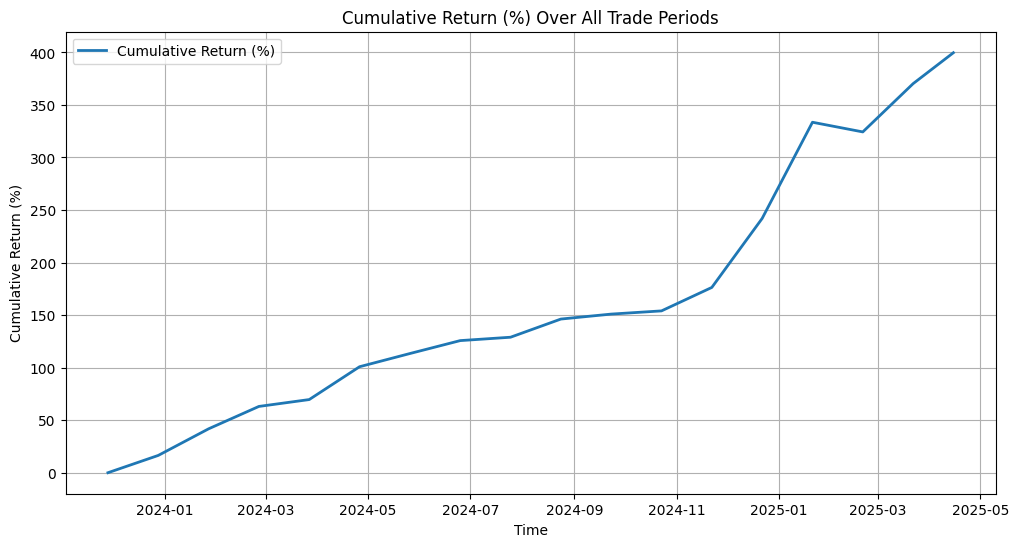


=== 전체 포트폴리오 최종 자본: 49969.79, 누적 수익률: 399.70% ===


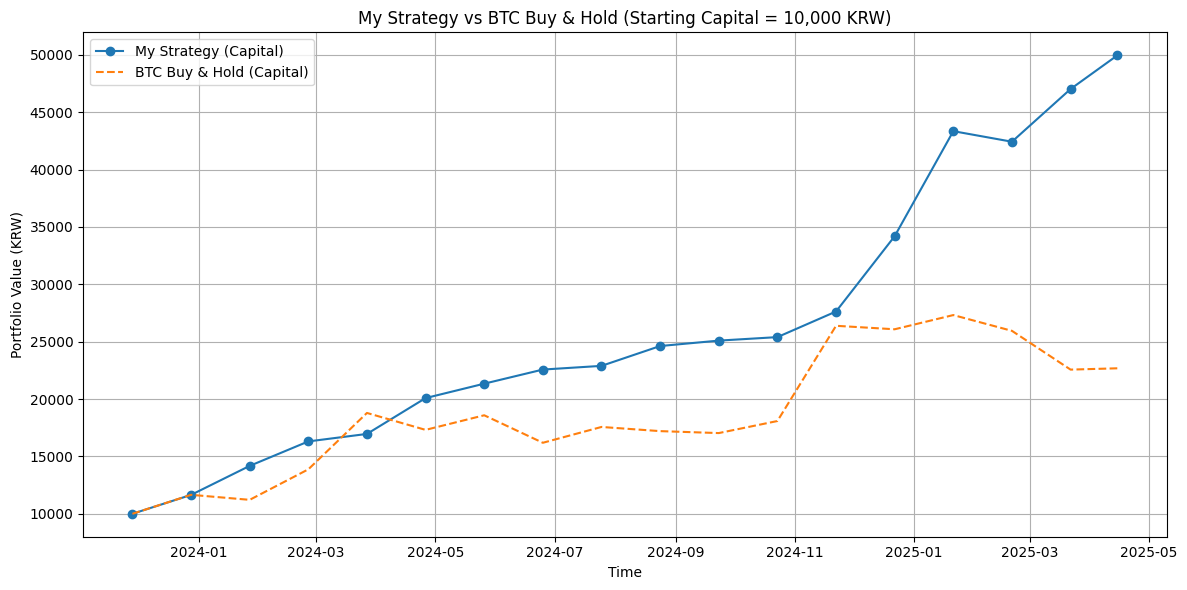

My Strategy: Sharpe=17.57, MDD=2.12%
BTC Buy & Hold: Sharpe=5.70, MDD=17.40%


(np.float64(5.6951730367703215), np.float64(-0.17402329389582494))

In [36]:
start_date = "2023-06-01"
end_date = "2025-04-15"
initial_capital = 10000
backtester = Backtester(price, start_date, end_date)
df_base = backtester.run_baseline_backtest(capital=initial_capital)
df_mine = backtester.run_backtest(ref_days=180, trade_days=30, initial_capital=initial_capital)

# My Strategy의 시작/종료 시점
mine_start = df_mine.index[0]
mine_end = df_mine.index[-1]

# 동일 기간 기준 Buy & Hold 수행
backtester.start_date = mine_start.strftime("%Y-%m-%d")
backtester.end_date = mine_end.strftime("%Y-%m-%d")
df_base = backtester.run_baseline_backtest(capital=initial_capital)

# My Strategy 자본 흐름
cum_o = df_mine['Cumulative Return (%)'] + 1  # 배수
my_equity = cum_o * initial_capital  # 누적 수익률 * 초기 자본

# BTC 자본 흐름 (동일 기간)
btc_series = price['BTC'].loc[df_mine.index]
btc_returns = btc_series.pct_change().fillna(0)
btc_cum = (1 + btc_returns).cumprod()
btc_equity = btc_cum / btc_cum.iloc[0] * initial_capital

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df_mine.index, my_equity, label='My Strategy (Capital)', marker='o')
plt.plot(df_mine.index, btc_equity, label='BTC Buy & Hold (Capital)', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Portfolio Value (KRW)")
plt.title("My Strategy vs BTC Buy & Hold (Starting Capital = 10,000 KRW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#정확한 Sharpe & MDD 계산
compute_sharpe_mdd(my_equity, name="My Strategy")
compute_sharpe_mdd(btc_equity, name="BTC Buy & Hold")

# 변형: 박스 기울기 추정

## 1. 검증

In [6]:
df_mine.head()

,Cumulative Return (%)
Exit Time,
2023-11-28,0.000000
2023-12-28,0.164612
2024-01-27,0.417670
2024-02-26,0.630881
2024-03-27,0.696205


In [11]:
price.head()

,ETH,BTC,BCH,XRP,EOS,LTC,TRX,ETC,LINK,XLM,...,LUNA,SHIB,BAL,CTK,LUNC,SNT,BADGER,VIDT,NULS,TROY
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-01 00:00:00,1875.63,27234.32,113.1,0.5156,0.891,90.54,0.07519,18.01,6.478,0.0924,...,0.8302,0.000009,5.210,0.721,0.000085,0.02341,2.423,0.02957,0.2165,0.002536
2023-06-01 00:05:00,1875.96,27241.68,113.2,0.5160,0.890,90.62,0.07518,18.01,6.478,0.0923,...,0.8299,0.000009,5.205,0.721,0.000084,0.02351,2.419,0.02957,0.2167,0.002531
2023-06-01 00:10:00,1884.79,27318.11,113.4,0.5155,0.893,90.97,0.07533,18.04,6.502,0.0924,...,0.8331,0.000009,5.236,0.723,0.000085,0.02354,2.432,0.02964,0.2174,0.002539
2023-06-01 00:15:00,1884.79,27287.80,113.4,0.5132,0.893,91.00,0.07533,18.04,6.501,0.0921,...,0.8322,0.000009,5.237,0.723,0.000085,0.02352,2.430,0.02964,0.2178,0.002538
2023-06-01 00:20:00,1886.40,27300.99,113.4,0.5129,0.893,91.22,0.07543,18.06,6.506,0.0922,...,0.8326,0.000009,5.239,0.724,0.000085,0.02353,2.431,0.02961,0.2178,0.002535


In [199]:
#price 데이터프레임 전체 scaling. 안 씀

# minmax scaling
from sklearn.preprocessing import MinMaxScaler

# 데이터 변환
mMscaler = MinMaxScaler()
scaled_values = mMscaler.fit_transform(price.values)
price_scaled = pd.DataFrame(scaled_values, index=price.index, columns=price.columns)

In [176]:
price_scaled.head()

,ETH,BTC,BCH,XRP,EOS,LTC,TRX,ETC,LINK,XLM,...,LUNA,SHIB,BAL,CTK,LUNC,SNT,BADGER,VIDT,NULS,TROY
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-01 00:00:00,0.177352,0.027860,0.031416,0.042596,0.436140,0.417878,0.027425,0.193572,0.058997,0.030997,...,0.512858,0.071156,0.823605,0.343202,0.152732,0.112104,0.179676,0.418888,0.183886,0.300025
2023-06-01 00:05:00,0.177475,0.027947,0.031577,0.042729,0.435248,0.418708,0.027398,0.193572,0.058997,0.030816,...,0.512637,0.071919,0.822682,0.343202,0.151893,0.113619,0.179242,0.418888,0.184082,0.299402
2023-06-01 00:10:00,0.180752,0.028856,0.031899,0.042562,0.437924,0.422342,0.027795,0.194680,0.059926,0.030997,...,0.515001,0.072935,0.828408,0.344740,0.153394,0.114074,0.180654,0.419943,0.184768,0.300399
2023-06-01 00:15:00,0.180752,0.028496,0.031899,0.041796,0.437924,0.422654,0.027795,0.194680,0.059888,0.030456,...,0.514336,0.073189,0.828593,0.344740,0.153085,0.113771,0.180436,0.419943,0.185160,0.300274
2023-06-01 00:20:00,0.181350,0.028653,0.031899,0.041696,0.437924,0.424938,0.028059,0.195419,0.060081,0.030636,...,0.514632,0.074460,0.828962,0.345509,0.153129,0.113922,0.180545,0.419491,0.185160,0.299900


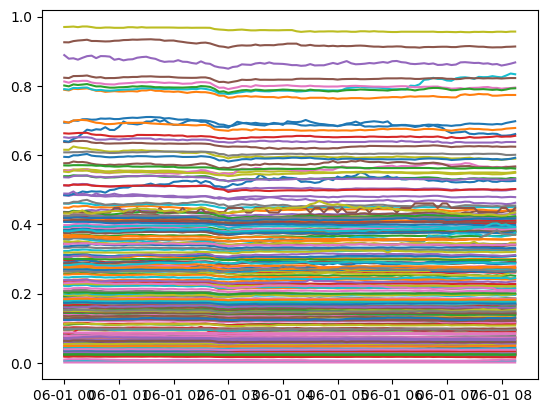

In [177]:
plt.plot(price_scaled.head(100))
plt.show()

In [38]:
trade_df.head()

,Entry Time,Exit Time,pair,Entry Position,Held Positions,Conflict Action,Trade Profit,Trade Return (%),Entry Capital,Exit Capital,...,Entry Price BNB,Exit Price BNB,Entry Price CVC,Exit Price CVC,Entry Price HIVE,Exit Price HIVE,Entry Price RAD,Exit Price RAD,Entry Price SFP,Exit Price SFP
0,2025-03-22 04:45:00,2025-03-22 09:55:00,"(CVC, RAD)",-1,{},none,221.581120,2.355899,9405.374048,9626.955168,...,NaN,NaN,0.0987,0.0995,NaN,NaN,0.805,0.859,NaN,NaN
1,2025-03-22 04:55:00,2025-03-22 10:55:00,"(BNB, AVA)",-1,"{'CVC': -1, 'RAD': 1}",none,34.166994,0.363271,9405.374048,9439.541042,...,629.98,628.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-03-22 06:25:00,2025-03-22 10:55:00,"(BNB, HIVE)",-1,"{'CVC': -1, 'RAD': 1, 'BNB': -1, 'AVA': 1}",none,35.394876,0.376326,9405.374048,9440.768924,...,631.55,628.19,NaN,NaN,0.2375,0.238,NaN,NaN,NaN,NaN
3,2025-03-22 07:35:00,2025-03-22 10:30:00,"(CVC, SFP)",-1,"{'CVC': -1, 'RAD': 1, 'BNB': -2, 'AVA': 1, 'HI...",none,29.816086,0.317011,9405.374048,9435.190134,...,NaN,NaN,0.0994,0.0990,NaN,NaN,NaN,NaN,0.5399,0.5422
4,2025-03-22 12:50:00,2025-03-22 15:50:00,"(CVC, SFP)",-1,{},none,21.195449,0.224643,9435.190134,9456.385583,...,NaN,NaN,0.0993,0.0992,NaN,NaN,NaN,NaN,0.5404,0.5429


In [28]:
# === Trade Records ===
#            Entry Time           Exit Time         pair  Entry Position  \
# 0  2025-03-22 04:45:00 2025-03-22 09:55:00   (CVC, RAD)              -1   
# 1  2025-03-22 04:55:00 2025-03-22 10:55:00   (BNB, AVA)              -1   
# 2  2025-03-22 06:25:00 2025-03-22 10:55:00  (BNB, HIVE)              -1   
# 3  2025-03-22 07:35:00 2025-03-22 10:30:00   (CVC, SFP)              -1   
# 4  2025-03-22 12:50:00 2025-03-22 15:50:00   (CVC, SFP)              -1   
# ..                 ...                 ...          ...             ...   
# 66 2025-04-12 14:35:00 2025-04-13 04:50:00  (BNB, AGLD)              -1   
# 67 2025-04-12 14:40:00 2025-04-13 00:05:00  (BNB, HIVE)              -1   
# 68 2025-04-12 16:05:00 2025-04-12 18:35:00   (CVC, RAD)              -1   
# 69 2025-04-12 22:50:00 2025-04-14 02:20:00   (CVC, RAD)              -1   
# 70 2025-04-13 01:00:00 2025-04-14 05:25:00   (CVC, SFP)              -1   

# 0  2025-03-22 04:45:00 2025-03-22 09:55:00   (CVC, RAD)              -1 

pair1 = 'CVC'
pair2 = 'RAD'
entry_date = pd.to_datetime('2025-03-22 04:45:00')
exit_date = pd.to_datetime('2025-03-22 09:55:00')

pair1_df = price[pair1].iloc[(price.index >= entry_date) & (price.index <= exit_date)]
pair2_df = price[pair2].iloc[(price.index >= entry_date) & (price.index <= exit_date)]

In [31]:
pair1_df

Date
2025-03-22 04:45:00    0.0987
2025-03-22 04:50:00    0.0987
2025-03-22 04:55:00    0.0986
2025-03-22 05:00:00    0.0986
2025-03-22 05:05:00    0.0986
                        ...  
2025-03-22 09:35:00    0.0998
2025-03-22 09:40:00    0.0998
2025-03-22 09:45:00    0.0998
2025-03-22 09:50:00    0.0997
2025-03-22 09:55:00    0.0995
Name: CVC, Length: 63, dtype: float64

In [32]:
pair2_df

Date
2025-03-22 04:45:00    0.805
2025-03-22 04:50:00    0.807
2025-03-22 04:55:00    0.807
2025-03-22 05:00:00    0.807
2025-03-22 05:05:00    0.807
                       ...  
2025-03-22 09:35:00    0.823
2025-03-22 09:40:00    0.823
2025-03-22 09:45:00    0.827
2025-03-22 09:50:00    0.838
2025-03-22 09:55:00    0.859
Name: RAD, Length: 63, dtype: float64

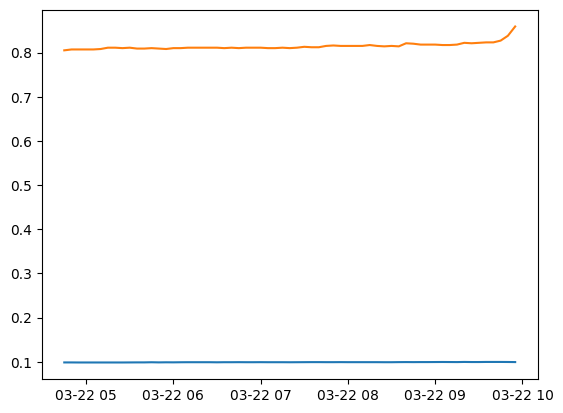

In [33]:
plt.plot(pair1_df)
plt.plot(pair2_df)
plt.show()

('CVC', 'SFP')
pair1: CVC
pair2: SFP
Entry: 2025-04-13 01:00:00
Exit: 2025-04-14 05:25:00
Trade Profit: 390.02392626257
Trade Return: 3.778142346324435 %
Entry Capital: 10323.166532939256
Exit Capital: 10713.190459201825


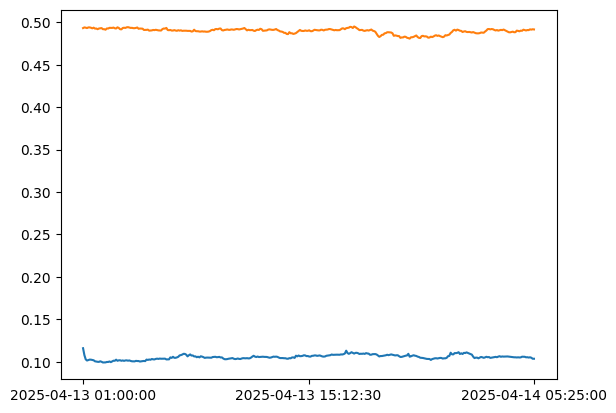

In [202]:
row = trade_df.loc[trade_df['Trade Profit'] == trade_df['Trade Profit'].max()].iloc[0]
pair = row['pair']; print(pair)
pair1 = pair[0]; print('pair1:', pair1)
pair2 = pair[1]; print('pair2:', pair2)
entry_date = row['Entry Time']; print('Entry:', entry_date)
exit_date = row['Exit Time']; print('Exit:', exit_date)

print('Trade Profit:', row['Trade Profit'])
print('Trade Return:', row['Trade Return (%)'], '%')
print('Entry Capital:', row['Entry Capital'])
print('Exit Capital:', row['Exit Capital'])

pair1_df = price[pair1].iloc[(price.index >= entry_date) & (price.index <= exit_date)]
pair2_df = price[pair2].iloc[(price.index >= entry_date) & (price.index <= exit_date)]

plt.plot(pair1_df)
plt.plot(pair2_df)
plt.xticks([entry_date, entry_date+(exit_date-entry_date)/2, exit_date], [entry_date, entry_date+(exit_date-entry_date)/2, exit_date])
plt.show()

pair1: CVC
pair2: RAD
Entry: 2025-03-22 04:45:00
Exit: 2025-03-22 09:55:00
Trade Profit: 221.58112004954367
Trade Return: 2.355899073433567 %
Entry Capital: 9405.374047989408
Exit Capital: 9626.955168038952


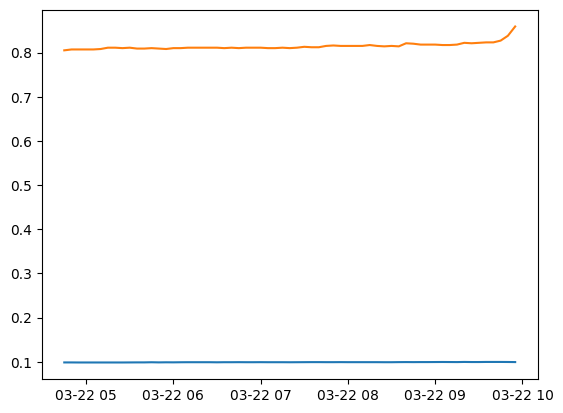

In [128]:
row = trade_df.iloc[0]

pair = row['pair']
pair1 = pair[0]; print('pair1:', pair1)
pair2 = pair[1]; print('pair2:', pair2)
entry_date = row['Entry Time']; print('Entry:', entry_date)
exit_date = row['Exit Time']; print('Exit:', exit_date)

print('Trade Profit:', row['Trade Profit'])
print('Trade Return:', row['Trade Return (%)'], '%')
print('Entry Capital:', row['Entry Capital'])
print('Exit Capital:', row['Exit Capital'])

pair1_df = price[pair1].iloc[(price.index >= entry_date) & (price.index <= exit_date)]
pair2_df = price[pair2].iloc[(price.index >= entry_date) & (price.index <= exit_date)]

plt.plot(pair1_df)
plt.plot(pair2_df)
plt.show()

('CVC', 'SFP')
pair1: CVC
pair2: SFP
Entry: 2025-04-13 01:00:00
Exit: 2025-04-14 05:25:00
Trade Profit: 390.02392626257
Trade Return: 3.778142346324435 %
Entry Capital: 10323.166532939256
Exit Capital: 10713.190459201825


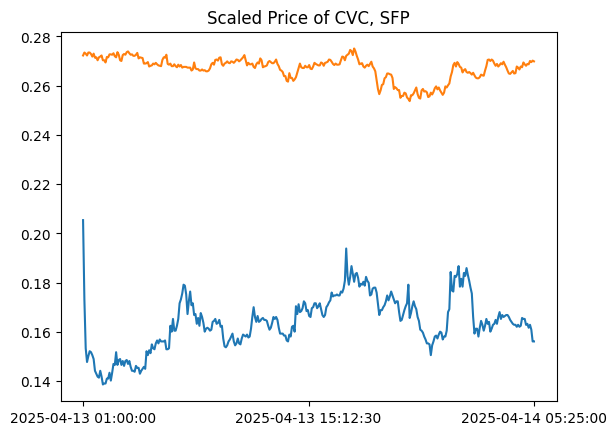

Entry Time                                       2025-04-13 01:00:00
Exit Time                                        2025-04-14 05:25:00
pair                                                      (CVC, SFP)
Entry Position                                                    -1
Held Positions           {'BNB': -1, 'AGLD': 1, 'CVC': -1, 'RAD': 1}
Conflict Action                                                 none
Trade Profit                                              390.023926
Trade Return (%)                                            3.778142
Entry Capital                                           10323.166533
Exit Capital                                            10713.190459
Total Capital                                           49969.792054
Cumulative Return (%)                                       3.996979
Entry Price AGLD                                                 NaN
Exit Price AGLD                                                  NaN
Entry Price AVA                   

In [273]:
# MinMax Scaled된 price 데이터 적용. 실패: 페어 될 것 2개만 뽑아낸 다음에 스케일링 해야 함.

row = trade_df.loc[trade_df['Trade Profit'] == trade_df['Trade Profit'].max()].iloc[0]
pair = row['pair']; print(pair)
pair1 = pair[0]; print('pair1:', pair1)
pair2 = pair[1]; print('pair2:', pair2)
entry_date = row['Entry Time']; print('Entry:', entry_date)
exit_date = row['Exit Time']; print('Exit:', exit_date)

print('Trade Profit:', row['Trade Profit'])
print('Trade Return:', row['Trade Return (%)'], '%')
print('Entry Capital:', row['Entry Capital'])
print('Exit Capital:', row['Exit Capital'])

pair1_df = price_scaled[pair1].iloc[(price_scaled.index >= entry_date) & (price_scaled.index <= exit_date)]
pair2_df = price_scaled[pair2].iloc[(price_scaled.index >= entry_date) & (price_scaled.index <= exit_date)]

plt.plot(pair1_df)
plt.plot(pair2_df)
plt.title(f'Scaled Price of {pair1}, {pair2}')
plt.xticks([entry_date, entry_date+(exit_date-entry_date)/2, exit_date], [entry_date, entry_date+(exit_date-entry_date)/2, exit_date])
plt.show()

row

('CVC', 'SFP')
pair1: CVC
pair2: SFP
Entry: 2025-04-13 01:00:00
Exit: 2025-04-14 05:25:00
Trade Profit: 390.02392626257
Trade Return: 3.778142346324435 %
Entry Capital: 10323.166532939256
Exit Capital: 10713.190459201825


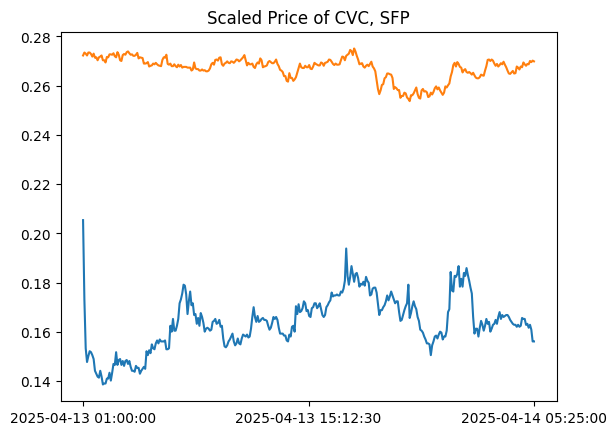

Entry Time                                       2025-04-13 01:00:00
Exit Time                                        2025-04-14 05:25:00
pair                                                      (CVC, SFP)
Entry Position                                                    -1
Held Positions           {'BNB': -1, 'AGLD': 1, 'CVC': -1, 'RAD': 1}
Conflict Action                                                 none
Trade Profit                                              390.023926
Trade Return (%)                                            3.778142
Entry Capital                                           10323.166533
Exit Capital                                            10713.190459
Total Capital                                           49969.792054
Cumulative Return (%)                                       3.996979
Entry Price AGLD                                                 NaN
Exit Price AGLD                                                  NaN
Entry Price AVA                   

In [275]:
# MinMax Scaled된 price 데이터 적용. 실패: 페어 될 것 2개만 뽑아낸 다음에 스케일링 해야 함.

row = trade_df.loc[trade_df['Trade Return (%)'] == trade_df['Trade Return (%)'].max()].iloc[0]
pair = row['pair']; print(pair)
pair1 = pair[0]; print('pair1:', pair1)
pair2 = pair[1]; print('pair2:', pair2)
entry_date = row['Entry Time']; print('Entry:', entry_date)
exit_date = row['Exit Time']; print('Exit:', exit_date)

print('Trade Profit:', row['Trade Profit'])
print('Trade Return:', row['Trade Return (%)'], '%')
print('Entry Capital:', row['Entry Capital'])
print('Exit Capital:', row['Exit Capital'])

pair1_df = price_scaled[pair1].iloc[(price_scaled.index >= entry_date) & (price_scaled.index <= exit_date)]
pair2_df = price_scaled[pair2].iloc[(price_scaled.index >= entry_date) & (price_scaled.index <= exit_date)]

plt.plot(pair1_df)
plt.plot(pair2_df)
plt.title(f'Scaled Price of {pair1}, {pair2}')
plt.xticks([entry_date, entry_date+(exit_date-entry_date)/2, exit_date], [entry_date, entry_date+(exit_date-entry_date)/2, exit_date])
plt.show()

row

In [277]:
trade_df.loc[trade_df['Trade Profit'] == trade_df['Trade Profit'].max()].iloc[0] == trade_df.loc[trade_df['Trade Return (%)'] == trade_df['Trade Return (%)'].max()].iloc[0]

Entry Time                True
Exit Time                 True
pair                      True
Entry Position            True
Held Positions            True
Conflict Action           True
Trade Profit              True
Trade Return (%)          True
Entry Capital             True
Exit Capital              True
Total Capital             True
Cumulative Return (%)     True
Entry Price AGLD         False
Exit Price AGLD          False
Entry Price AVA          False
Exit Price AVA           False
Entry Price BNB          False
Exit Price BNB           False
Entry Price CVC           True
Exit Price CVC            True
Entry Price HIVE         False
Exit Price HIVE          False
Entry Price RAD          False
Exit Price RAD           False
Entry Price SFP           True
Exit Price SFP            True
Name: 70, dtype: bool

### 페어 가격비교선 최종 완성본

In [ ]:
# minmax scaling
from sklearn.preprocessing import MinMaxScaler

rownum: 1
pair1: BNB
pair2: AVA
Entry: 2025-03-22 04:55:00
Exit: 2025-03-22 10:55:00
Trade Profit: 34.166993753608054
Trade Return: 0.3632709723108987 %
Entry Capital: 9405.374047989408
Exit Capital: 9439.541041743016


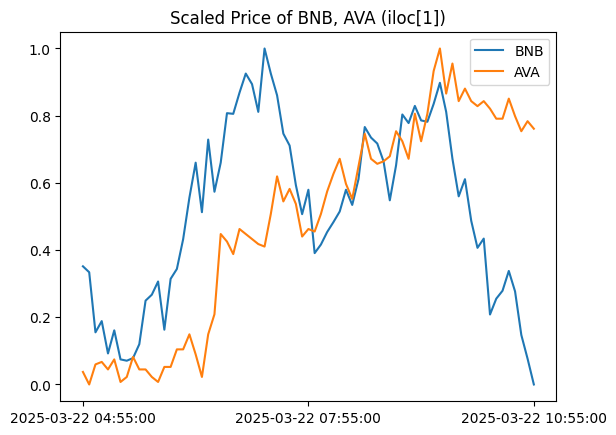

In [235]:
rownum = 1 # trade_df에서 결과 보고 싶은 행 번호 입력
row = trade_df.iloc[rownum]; print('rownum:', rownum)

pair = row['pair']
pair1 = pair[0]; print('pair1:', pair1)
pair2 = pair[1]; print('pair2:', pair2)
entry_date = row['Entry Time']; print('Entry:', entry_date)
exit_date = row['Exit Time']; print('Exit:', exit_date)

print('Trade Profit:', row['Trade Profit'])
print('Trade Return:', row['Trade Return (%)'], '%')
print('Entry Capital:', row['Entry Capital'])
print('Exit Capital:', row['Exit Capital'])

mMscaler = MinMaxScaler()

pair1_df = price[pair1].iloc[(price.index >= entry_date) & (price.index <= exit_date)]
pair2_df = price[pair2].iloc[(price.index >= entry_date) & (price.index <= exit_date)]
pair_df = pd.concat([pair1_df, pair2_df], axis=1)

pair_df_scaled = pd.DataFrame(mMscaler.fit_transform(pair_df.values), index=pair_df.index, columns=pair_df.columns)

plt.plot(pair_df_scaled[pair1], label=pair1)
plt.plot(pair_df_scaled[pair2], label=pair2)
plt.title(f'Scaled Price of {pair1}, {pair2} (iloc[{rownum}])')
plt.xticks([entry_date, entry_date+(exit_date-entry_date)/2, exit_date], [entry_date, entry_date+(exit_date-entry_date)/2, exit_date])
plt.legend()
plt.show()

In [242]:
def asdf(rownum) :
    rownum = rownum # trade_df에서 결과 보고 싶은 행 번호 입력
    row = trade_df.iloc[rownum]; print('rownum:', rownum)
    
    pair = row['pair']
    pair1 = pair[0]; print('pair1:', pair1)
    pair2 = pair[1]; print('pair2:', pair2)
    entry_date = row['Entry Time']; print('Entry:', entry_date)
    exit_date = row['Exit Time']; print('Exit:', exit_date)
    
    print('Trade Profit:', row['Trade Profit'])
    print('Trade Return:', row['Trade Return (%)'], '%')
    print('Entry Capital:', row['Entry Capital'])
    print('Exit Capital:', row['Exit Capital'])
    
    mMscaler = MinMaxScaler()
    
    pair1_df = price[pair1].iloc[(price.index >= entry_date) & (price.index <= exit_date)]
    pair2_df = price[pair2].iloc[(price.index >= entry_date) & (price.index <= exit_date)]
    pair_df = pd.concat([pair1_df, pair2_df], axis=1)
    
    pair_df_scaled = pd.DataFrame(mMscaler.fit_transform(pair_df.values), index=pair_df.index, columns=pair_df.columns)
    
    plt.plot(pair_df_scaled[pair1], label=pair1)
    plt.plot(pair_df_scaled[pair2], label=pair2)
    plt.title(f'Scaled Price of {pair1}, {pair2} (iloc[{rownum}])')
    plt.xticks([entry_date, entry_date+(exit_date-entry_date)/2, exit_date], [entry_date, entry_date+(exit_date-entry_date)/2, exit_date])
    plt.legend()
    plt.show()

rownum: 0
pair1: CVC
pair2: RAD
Entry: 2025-03-22 04:45:00
Exit: 2025-03-22 09:55:00
Trade Profit: 221.58112004954367
Trade Return: 2.355899073433567 %
Entry Capital: 9405.374047989408
Exit Capital: 9626.955168038952


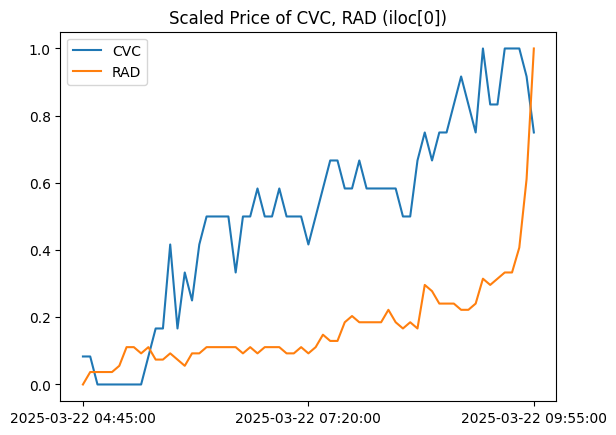

In [265]:
asdf(0)

코드 넘기기: trade_df, price, asdf 사용한 새 파일 생성

In [255]:
trade_df.to_csv('250505_standard_choi_trade_df.csv')

In [256]:
price.to_csv('250505_standard_choi_price.csv')

In [257]:
trade_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Entry Time             71 non-null     datetime64[ns]
 1   Exit Time              71 non-null     datetime64[ns]
 2   pair                   71 non-null     object        
 3   Entry Position         71 non-null     int64         
 4   Held Positions         71 non-null     object        
 5   Conflict Action        71 non-null     object        
 6   Trade Profit           71 non-null     float64       
 7   Trade Return (%)       71 non-null     float64       
 8   Entry Capital          71 non-null     float64       
 9   Exit Capital           71 non-null     float64       
 10  Total Capital          71 non-null     float64       
 11  Cumulative Return (%)  71 non-null     float64       
 12  Entry Price AGLD       16 non-null     float64       
 13  Exit Pr

In [262]:
type(trade_df.iloc[0]['pair'])

tuple

In [1]:
price

NameError: name 'price' is not defined